# 1-D Inference with Redshifts

Part 2 of a series of notebooks used to derive the results shown in Speagle et al. (2017).

This notebook outlines how to derive population redshift distributions from a given collection of **redshift probability density functions (PDFs)**. This simple case allows us to introduce most of the critical ideas and extensions that serve as the foundation for $p$-D **photometric PDF** inference in later notebooks.

## Setup

In [1]:
import sys # system commands
import pickle # saving data
from scipy import stats # statistics functions
from scipy import special # special functions
from scipy import interpolate # interpolation
from sklearn.neighbors import KernelDensity # kernel density estimation
from pandas.tools.plotting import autocorrelation_plot # autocorrelation plot

# simulation
import make_sim as sim

# FRANKEN-Z
import frankenz as fz

%pylab
%matplotlib inline

# re-defining plotting defaults
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


## Data

For our proof-of-concept tests, we will use the mock SDSS data we previously generated.

In [2]:
downsample = 25 # downsampling the population
sdss = pickle.load(open( "data/mock_sdss_cosmos_bpz.p", "rb" )) # load data
[types, redshifts, mags], templates = sdss.samples[:,::downsample], sdss.samples_t[::downsample] # import truth labels
Nobs = sdss.NSAMPLES/downsample

## Population Redshift Density Estimation

### Noiseless Case

For every observed galaxy $g \in \mathbf{g}$, we have an associated redshift estimate $z_g$ with no measurement errors such that the corresponding redshift PDF is $P(z|z_g)=\delta(z-z_g)$. We can construct an estimate for the population redshift distribution $N(z|\mathbf{g})$ by projecting our results onto a relevant **redshift basis** $\lbrace \dots, P(z|z_h) , \dots \rbrace$ indexed by $h \in \mathbf{h}$ via

$$
P(z_g|z_h) \equiv P(g|h) = \int P(z|z_h) P(z|z_g) P(z) dz \quad .
$$

#### Histogram

One common choice of basis is a series of redshift **bins**, which can be modeled as a product of Heavyside functions

$$
P(z|z_h) = \mathcal{H}(z - z_h^{-})\mathcal{H}(z_h^{+} - z), \quad z_h^{\pm} = (z_h \pm \Delta z_h)/2
$$

where $z_h^{\pm}$ are the bin edges, $z_h$ is the bin center, and $\Delta z_h$ is the bin width. Assuming our redshift prior $P(z)$ is uniform, 

$$
P(g|h) = \int \mathcal{H}(z - z_h^{-})\mathcal{H}(z_h^{+} - z) \, \delta(z-z_g) \, dz = \mathcal{H}(z_g - z_h^{-})\mathcal{H}(z_h^{+} - z_g) \quad ,
$$

which is $1$ if $z_h^{-} < z_g \leq z_h^{+}$ and $0$ otherwise. (Note that behavior at the edges can be constrained by definition to keep bin assignments unique.)

Defining our collection of bin edges as $\mathbf{z}^{\pm} = \lbrace \dots, z_h^{\pm}, \dots \rbrace$, we can define our projection over this basis using **Bayes Theorem** as

$$
N(\mathbf{h}|\mathbf{g}) \equiv \sum_{g \in \mathbf{g}} P(\mathbf{h}|g) = \sum_{g \in \mathbf{g}} \frac{P(g|\mathbf{h})P(\mathbf{h})}{P(g)} = \sum_{g \in \mathbf{g}} \mathcal{H}(z_g - \mathbf{z}^{-})\mathcal{H}(\mathbf{z}^{+} - z_g) 
$$

where we have assumed our *prior* $P(\mathbf{h})$ over our redshift bins is uniform, and the *evidence* $P(g) = \sum_{h \in \mathbf{h}} P(g|h) P(h) = 1$.

The formalism seems somewhat complicated, but in the end is equivalent to just counting how many galaxies end up in each redshift bin. Our underlying continuous estimate of the redshift number density $N(z|\mathbf{g})$ is then just some (appropriately normalized) interpolation over our discrete $N(\mathbf{z}|\mathbf{g})$ basis.

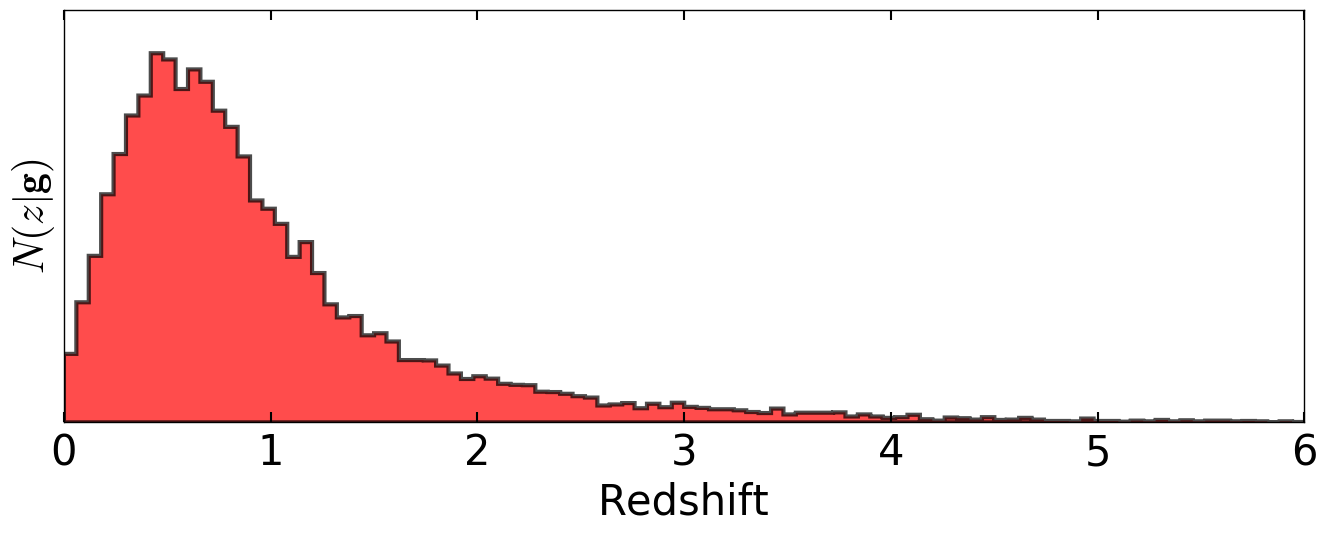

In [3]:
zbins = linspace(0,6,100+1) # redshift bins

# plotting
figure(figsize=(14,6))
h = hist(redshifts, bins=zbins, histtype='stepfilled', lw=3, color='red', alpha=0.7)
xlabel('Redshift')
yticks([])
ylabel('$N(z|\mathbf{g})$')
tight_layout()

#### Kernel Density Estimation

Alternately, we can construct a smooth density estimate by "flipping" the roles played by our $P(z|z_g)$'s and $P(z|z_h)$'s. Using **kernel density estimation (KDE)**, we can approximate the underlying density spanned by all $z_g$'s by assigning each $z_g$ a corresponding *kernel density* $K_g(z|z_g)$. In other words, we assume that each object contributes some probability at some redshift smoothing scale, rather than being a discrete sample. Let's choose a Normal (Gaussian) kernel centered at $z_g$ with a smoothing scale equivalent to the spacing of our grid $\sigma_z = \Delta z = 10^{-2}$ such that $P(z|z_g) = K_g(z|z_g)=\mathcal{N}(z|\mu=z_g, \sigma^2=10^{-4})$.

We now want to sample this smooth function over some basis. The most straightforward is a simple redshift grid $\mathbf{z} = \lbrace \dots, z_h, \dots \rbrace$ indexed by $h$ composed of delta functions such that $P(z|z_h)=\delta(z-z_h)$. Our corresponding estimate is then

$$
N(\mathbf{h}|\mathbf{g}) = N(\mathbf{z}|\mathbf{g}) = \sum_{g \in \mathbf{g}} \mathcal{N}(\mathbf{z}|z_g,\sigma_z^2) \quad .
$$

This results in a smoother, continuous estimate than can be more directly translated into $N(z|\mathbf{g})$ at the cost of no longer being a simple counting process.

Using some functionality from FRANKEN-Z we compute and plot this below.

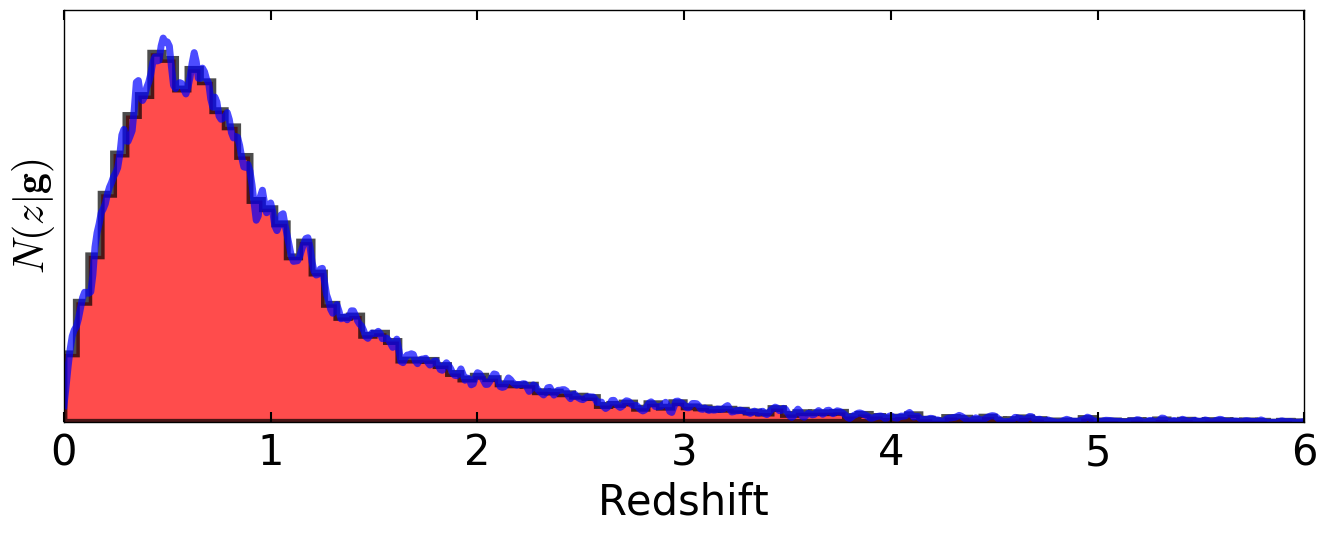

In [4]:
# redshift grid
dz, Nz = 0.01, 600+1
zgrid = arange(0, dz*Nz, dz)

# KDE
pdf = fz.pdf_kde(redshifts, ones(Nobs)*dz, ones(Nobs), zgrid, dz, Nobs, Nz)
pdf /= trapz(pdf, zgrid)

# plotting
figure(figsize=(14,6))
h = hist(redshifts, bins=zbins, histtype='stepfilled', lw=5, color='red', alpha=0.7, normed=True)
plot(zgrid, pdf, lw=5, color='blue', alpha=0.7)
xlabel('Redshift')
yticks([])
ylabel('$N(z|\mathbf{g})$')
tight_layout()

### Noisy Case

Now let's imagine that we don't actually have access to $z_g$, but only a redshift **probability density function (PDF)** $P(z|g)$ such that

$$
P(z_g|z_h) \equiv P(g|h) = \int \delta(z-z_h) P(z|g) P(z) dz = P(z_h|g) P(z_h) \quad .
$$

Functionally, we simulate this by defining our PDFs as kernels $K_g(z|z_g)$ centered around the noisy estimates $\hat{z}_g$ with variable $\sigma_g$.

In [5]:
# generate PDFs
sigma = uniform(0.01, 0.1, size=Nobs) # width
mu = normal(redshifts, sigma) # noisy observation
zpdf = array([fz.gaussian(mu[i], sigma[i], zgrid) for i in xrange(Nobs)]) # redshift pdfs
zpdf /= trapz(zpdf, zgrid)[:,None] # normalizing

Commonly, it is assumed that stacking these PDFs such that

$$
P(\mathbf{z}|\mathbf{g}) = \sum_{g \in \mathbf{g}} \mathcal{N}(\mathbf{z}|\hat{z}_g, \hat{\sigma}_g^2)
$$

just like with our original KDE case will give access to the population distribution. We plot this below.

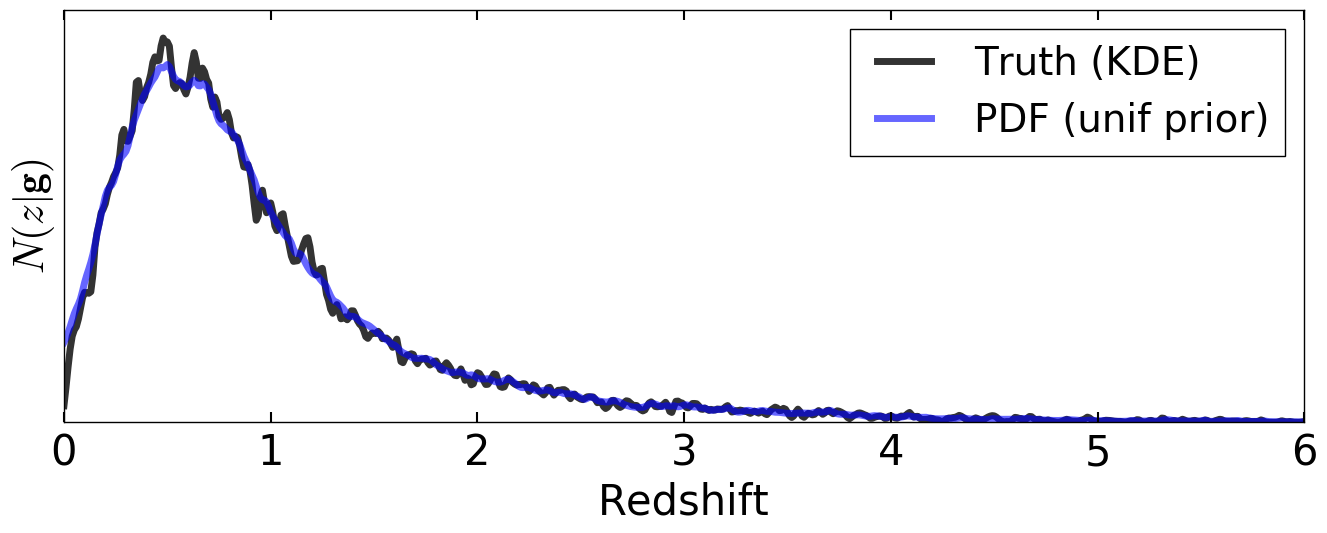

In [6]:
# plotting
figure(figsize=(14,6))
plot(zgrid, pdf*Nobs, lw=5, color='black', alpha=0.8, label='Truth (KDE)')
plot(zgrid, zpdf.sum(axis=0), lw=5, color='blue', alpha=0.6, label='PDF (unif prior)')
xlabel('Redshift')
yticks([])
ylabel('$N(z|\mathbf{g})$')
legend(fontsize=28, loc='best')
tight_layout()

Now that we're using PDFs instead of the true observed estimates, we can see this is not actually a proper reconstruction of the true PDF -- our noise broadens the estimated population redshift distribution (especially at the low redshift end). To properly account for this, we need to (re-)introduce a prior $P(\mathbf{h})$ over $\mathbf{h}$, i.e. a redshift prior $P(z)$ evaluated at $\mathbf{z}$. We then get

$$
P(g|\mathbf{h}) \equiv P(g|\mathbf{z}) = \int \delta(z-\mathbf{z}) P(z|g) P(z) dz = \frac{\mathcal{N}(\mathbf{z}|\hat{z}_g, \hat{\sigma}_g^2) P(\mathbf{z})}{\sum_{z_h \in \mathbf{z}} \mathcal{N}(z_h|\hat{z}_g, \hat{\sigma}_g^2) P(z_h)}
$$

and so

$$
P(\mathbf{z}|\mathbf{g}) = \sum_{g \in \mathbf{g}} \frac{\mathcal{N}(\mathbf{z}|\hat{z}_g, \hat{\sigma}_g^2) P(\mathbf{z})}{\sum_{z_h \in \mathbf{z}} \mathcal{N}(z_h|\hat{z}_g, \hat{\sigma}_g^2) P(z_h)}
$$

For our prior, let's put in the "true" redshift distribution computed previously using KDE.

In [7]:
znew = zpdf.copy()
for i in xrange(Nobs):
    znew[i] *= pdf
    znew[i] /= trapz(znew[i], zgrid)

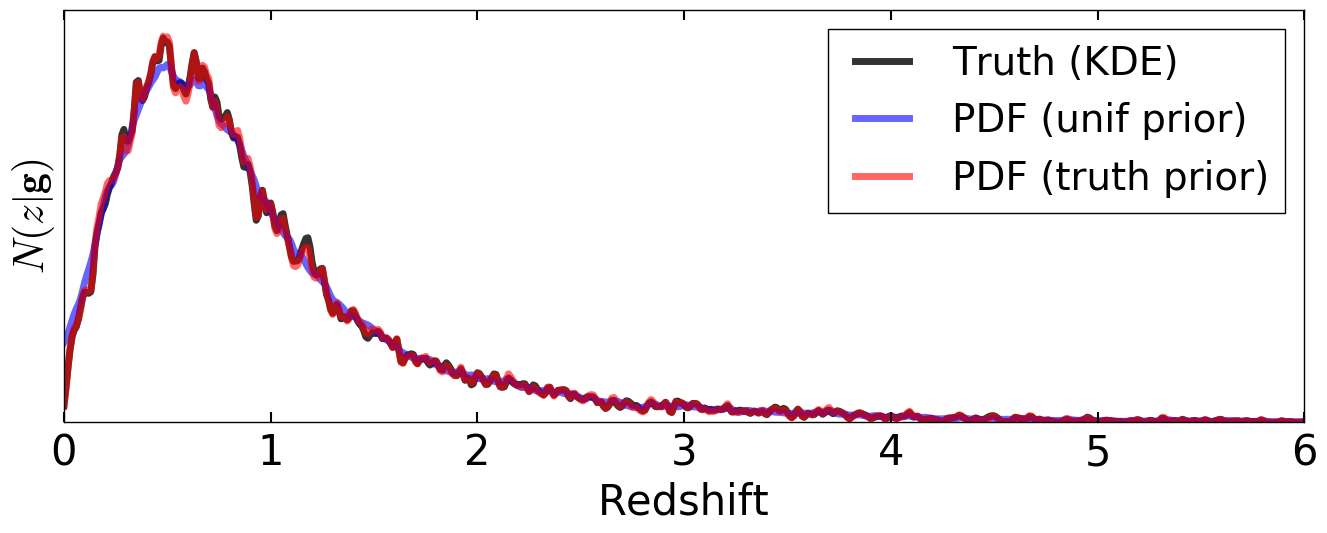

In [8]:
# plotting
figure(figsize=(14,6))
plot(zgrid, pdf*Nobs, lw=5, color='black', alpha=0.8, label='Truth (KDE)')
plot(zgrid, zpdf.sum(axis=0), lw=5, color='blue', alpha=0.6, label='PDF (unif prior)')
plot(zgrid, znew.sum(axis=0), lw=5, color='red', alpha=0.6, label='PDF (truth prior)')
xlabel('Redshift')
yticks([])
ylabel('$N(z|\mathbf{g})$')
legend(fontsize=28, loc='best')
tight_layout()

As expected, computing the redshift posterior using the true, underlying prior distribution reproduces the original result quite well. The problem, of course, is that in practice we have no idea what $P(z)$ or $P(\mathbf{h})$ should be.

## From Grids to Samples

So far we've assumed that our basis functions $h \in \mathbf{h}$ correspond to a grid in redshift $z_h \in \mathbf{z}$. Above, we found that to properly reproduce the true $N(z|\mathbf{g})$ we need to incorporate a proper redshift prior $P(z)$. Given our discrete grid, this translates to a set of discrete priors $P(z_h) \equiv P(h) \in P(\mathbf{h})$ over $\mathbf{h}$, where our basis over $\mathbf{h}$ just happens to correspond to a grid in redshift $\mathbf{z}$. Adopting our original notation, we can write this more formally/explicitly as

$$
P(h|g) = \frac{P(g|h) P(h)}{P(g)} \propto P(g|h) P(h)
$$

where

$$
P(g|h) \equiv \int P(z|h) P(z|g) dz, \quad P(h) = \frac{\int P(z|h) P(z|g) P(z) dz}{\int P(z|h) P(z|g) dz}, \quad P(g) = \sum_{h \in \mathbf{h}} P(g|h)P(h) \quad .
$$

For the case that $P(z|h) = \delta(z-z_h)$ (i.e. redshift point estimates), this immediately reduces to $P(g|h) = P(z_h|g)$ and $P(h) = P(z_h)$. If, however, our underlying set of basis functions are *not* point estimates, then we'd nominally have to compute the whole integral (unless we can find some analytic solution, as shown below).

We now want to take advantage of two key insights:
1. Our choice of basis is arbitrary, and we're free to pick our $h \in \mathbf{h}$ and their corresponding $\lbrace \dots, P(z|h), \dots \rbrace$ however we'd like.
2. Our basis can provide information on our prior.

In particular, if we assume that $h \in \mathbf{h}$ is a **(Poisson) point process** drawn from the underlying $P(z)$ distribution (i.e. the "true" prior), then aggregating information over these redshift samples is *fundamentally equivalent* in the limit where $n \rightarrow \infty$ to weighting a set of predictions computed over a redshift grid $\mathbf{z}$ by our corresponding prior $P(\mathbf{z})$. In other words, we just transition from a prior imposed directly in probability to a prior imposed indirectly via the associated number densities of objects.

From a **machine learning** perspective, we can interpret these samples as a **training set** that we exploit to make predictions. We'll start using a bit more of this terminology to emphasize some of the connections between machine learning and this point process formalism as we move further throughout the notebooks. See Speagle et al. (2017) for more details.

### Noiseless Samples

We first consider the case where our samples are noiseless and drawn directly from the redshift distribution of interest. Our log-likelihood then becomes

$$
\chi^2(g|h) \equiv -2\ln P(g|h) = -2\ln \left[ \int P(z|h) P(z|g) dz \right] = -2\ln \left[ \int \delta(z-z_h) \mathcal{N}(z|\hat{z}_g, \hat{\sigma}_g^2) dz \right] = -2\ln \left[ \mathcal{N}(z_h|\hat{z}_g,\hat{\sigma}_g^2) \right] = \frac{(\hat{z}_g-z_h)^2}{\hat{\sigma}_g^2} \quad ,
$$

ignoring some normalizing constants.

In [9]:
Ntrain = 1000 # number of training samples

In [10]:
cdf = pdf.cumsum()/pdf.sum() # compute CDF
ztrain = interp(rand(Ntrain), cdf, zgrid) # sample from underlying distribution

In [11]:
# stack results
ztrain_wt = zeros(Ntrain)
znorm = zeros(Nobs)
for i in arange(Nobs):
    if i%20000 == 0: sys.stdout.write(str(i)+' ')
    chi2 = ((ztrain - mu[i]) / sigma[i])**2
    chi2min = chi2.min()
    wt = exp(-0.5*(chi2-chi2min))
    norm = wt.sum()
    znorm[i] = norm / exp(-0.5*chi2min)
    ztrain_wt += wt/norm

0 

We then can estimate $N(z|\mathbf{g})$ as before using KDE.

In [12]:
# KDE
pdftrain = fz.pdf_kde(ztrain, ones(Ntrain)*dz, ztrain_wt, zgrid, dz, Ntrain, Nz)
pdftrain /= trapz(pdftrain, zgrid)

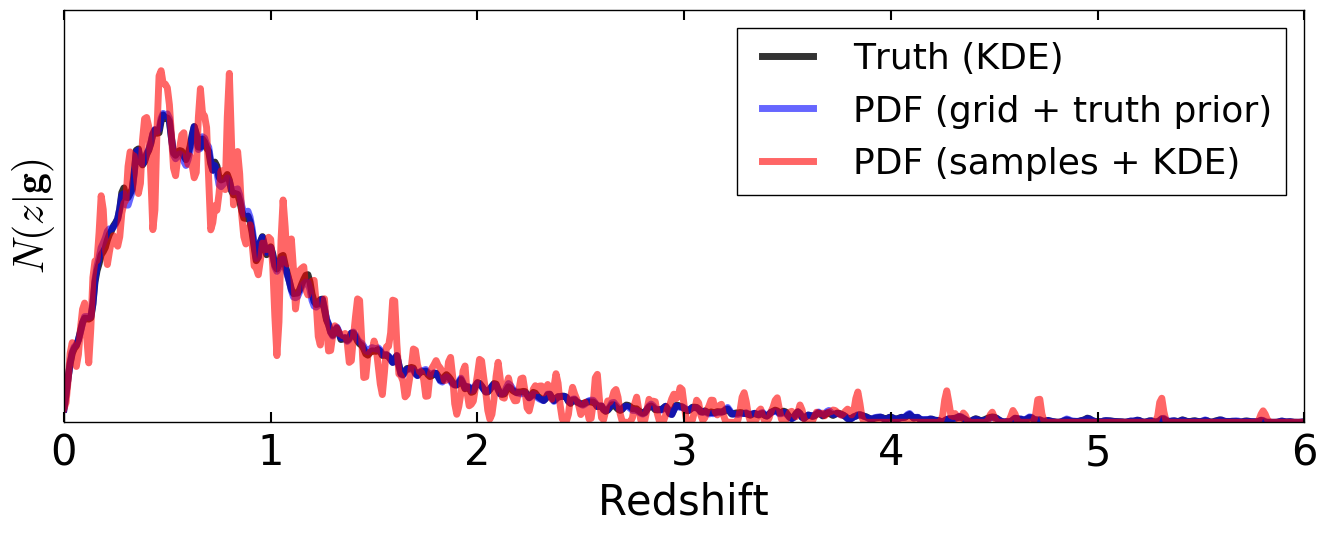

In [13]:
# plotting
figure(figsize=(14,6))
plot(zgrid, pdf*Nobs, lw=5, color='black', alpha=0.8, label='Truth (KDE)')
plot(zgrid, znew.sum(axis=0), lw=5, color='blue', alpha=0.6, label='PDF (grid + truth prior)')
plot(zgrid, pdftrain*Nobs, lw=5, color='red', alpha=0.6, label='PDF (samples + KDE)')
xlabel('Redshift')
yticks([])
ylabel('$N(z|\mathbf{g})$')
legend(fontsize=26, loc='best')
tight_layout()

While this estimate is accurate overall, it's subject to a some additional noise due to sampling variance. As a result, it relies on there being a *lot* of samples available for estimation, especially if we want to probe the tails of the redshift distribution.

### Noisy Samples

We now consider the case where our samples/training data are *also* noisy redshift estimates characterized by a redshift PDF $P(z|h)$. As with the switch from noiseless to noisy redshifts for $g \in \mathbf{g}$, we again model this switch for $h \in \mathbf{h}$ by modeling our PDFs as Gaussian kernels can with noisy redshifts and variables widths. The log-likelihood then becomes (up to some normalizing constants)

$$
\chi^2(g|h) = \frac{(\hat{z}_g-\hat{z}_h)^2}{\sigma_g^2+\sigma_h^2} \quad .
$$

In [14]:
# sample redshifts
ztrain = interp(rand(Ntrain), cdf, zgrid)

# generate PDFs
sigma_train = uniform(0.01, 0.1, size=Ntrain) # width
var_train = sigma_train**2
mu_train = normal(ztrain, sigma_train) # noisy observation

In [15]:
# stack results
ztrain_wt2 = zeros(Ntrain)
znorm2 = zeros(Nobs)
for i in arange(Nobs):
    if i%20000 == 0: sys.stdout.write(str(i)+' ')
    chi2 = (mu_train - mu[i])**2 / (sigma[i]**2 + var_train)
    chi2min = chi2.min()
    wt = exp(-0.5*(chi2-chi2min))
    norm = wt.sum()
    znorm2[i] = norm / exp(-0.5*chi2min)
    ztrain_wt2 += wt/norm

0 

We now stack the corresponding kernels.

In [16]:
# KDE
pdftrain2 = fz.pdf_kde(mu_train, sigma_train, ztrain_wt2, zgrid, dz, Ntrain, Nz)
pdftrain2 /= trapz(pdftrain2, zgrid)

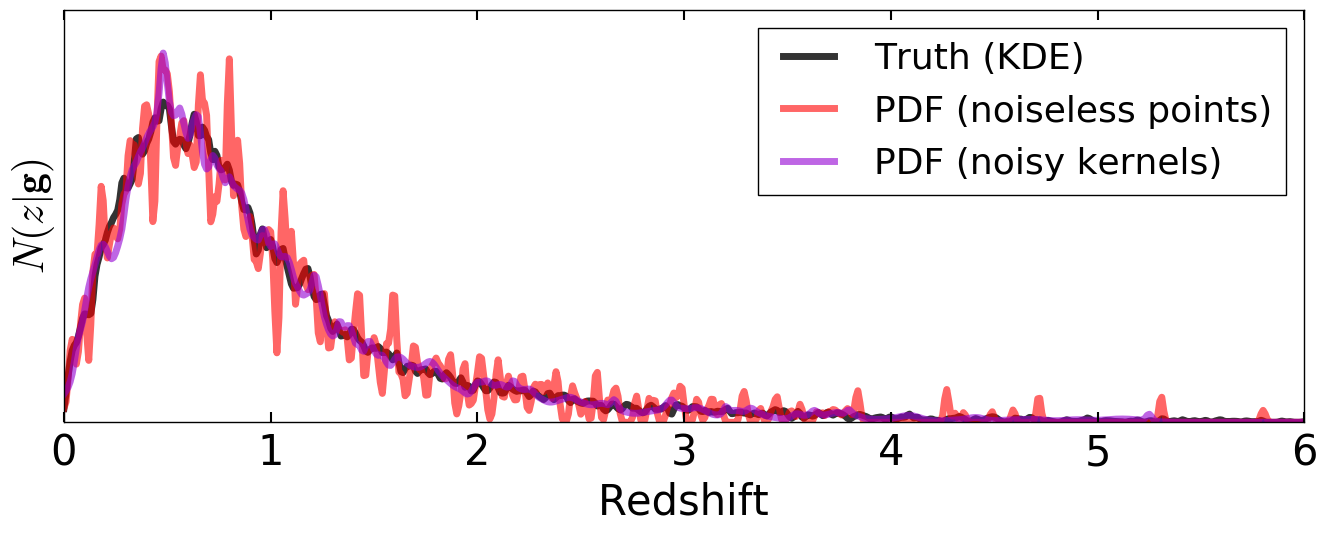

In [17]:
# plotting
figure(figsize=(14,6))
plot(zgrid, pdf, lw=5, color='black', alpha=0.8, label='Truth (KDE)')
plot(zgrid, pdftrain, lw=5, color='red', alpha=0.6, label=r'PDF (noiseless points)')
plot(zgrid, pdftrain2, lw=5, color='darkviolet', alpha=0.6, label=r'PDF (noisy kernels)')
xlabel('Redshift')
yticks([])
ylabel('$N(z|\mathbf{g})$')
legend(fontsize=26, loc='best')
tight_layout()

By eye, it can immediately be seen that our PDF using the same number of "noisy" samples is actually a much better representation than our PDF using noiseless samples. What gives?

There are three reasons for this:
1. It makes a difference whether a probabilistic basis is incorporated directly into the likelihoods or implemented afterwards. In the noiseless case, we applied KDE afterwards rather than assigning each object its own kernel when deriving our likelihoods, which ignores the intrinsic width of the kernel.
2. The smoothing scale for our inference is set by the width of our kernels. In the noiseless case, we chose the same smoothing scale ($\Delta z = 0.01$) used for our grid, while for the noisy case our smoothing scale varies from $\Delta z = 0.01 - 0.1$. This sets the scale for variation, and since the total number of samples we are using is relatively small, we would expect a broader smoothing scale to give better results in general.
3. While each individual PDF from our noisy sample is a noisy draw from the underlying density, across the ensemble the noise generally averages out, giving an unbaised representation of the true underlying distribution.

Just to demonstrate the impact of these effects, we use a series of broader noiseless kernels to re-derive our original noiseless $N(z|\mathbf{g})$ below.

In [18]:
# sample redshifts
ztrain = interp(rand(Ntrain), cdf, zgrid)
smooth = 0.05

# stack results
ztrain_wt3 = zeros(Ntrain)
znorm3 = zeros(Nobs)
for i in arange(Nobs):
    if i%20000 == 0: sys.stdout.write(str(i)+' ')
    chi2 = (ztrain - mu[i])**2 / (sigma[i]**2 + smooth**2)
    chi2min = chi2.min()
    wt = exp(-0.5*(chi2-chi2min))
    norm = wt.sum()
    znorm3[i] = norm / exp(-0.5*chi2min)
    ztrain_wt3 += wt/norm

0 

In [19]:
# KDE
pdftrain3 = fz.pdf_kde(ztrain, ones(Ntrain)*smooth, ztrain_wt3, zgrid, dz, Ntrain, Nz)
pdftrain3 /= trapz(pdftrain3, zgrid)

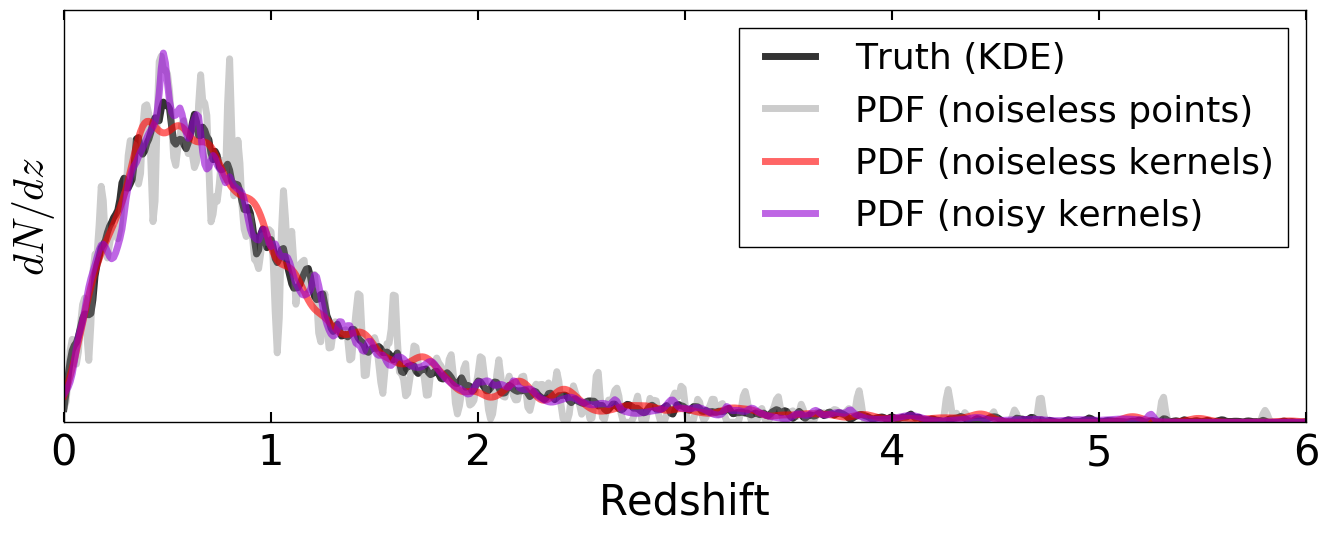

In [20]:
# plotting
figure(figsize=(14,6))
plot(zgrid, pdf, lw=5, color='black', alpha=0.8, label='Truth (KDE)')
plot(zgrid, pdftrain, lw=5, color='gray', alpha=0.4, label=r'PDF (noiseless points)')
plot(zgrid, pdftrain3, lw=5, color='red', alpha=0.6, label=r'PDF (noiseless kernels)')
plot(zgrid, pdftrain2, lw=5, color='darkviolet', alpha=0.6, label=r'PDF (noisy kernels)')
xlabel('Redshift')
yticks([])
ylabel('$dN/dz$')
legend(fontsize=26, loc='best')
tight_layout()

As expected, we do a significantly better job recovering the underlying distribution once we properly incorporate a set of broader kernels directly into our likelihoods.

## Sidenote: Coverage

One of the risks that becomes immediately apparent moving from grids to samples is the issue of **coverage**. In other words, our training data may not adequately cover all of the space spanned by our observable PDFs. We can diagnose this by looking at the **evidence** $P(g)$ (i.e. the normalization term we've ignored up until now!) computed for our objects. This gives a direct probe that tells us how much of our $\lbrace \dots, P(z|h), \dots \rbrace$ basis overlaps with each individual $P(z|g)$. We can then choose a given threshold (say $P(g)>1$, i.e. that our kernels cumulatively overlap with at least one observed PDF) that signifies whether a given prediction can or cannot be "trusted".

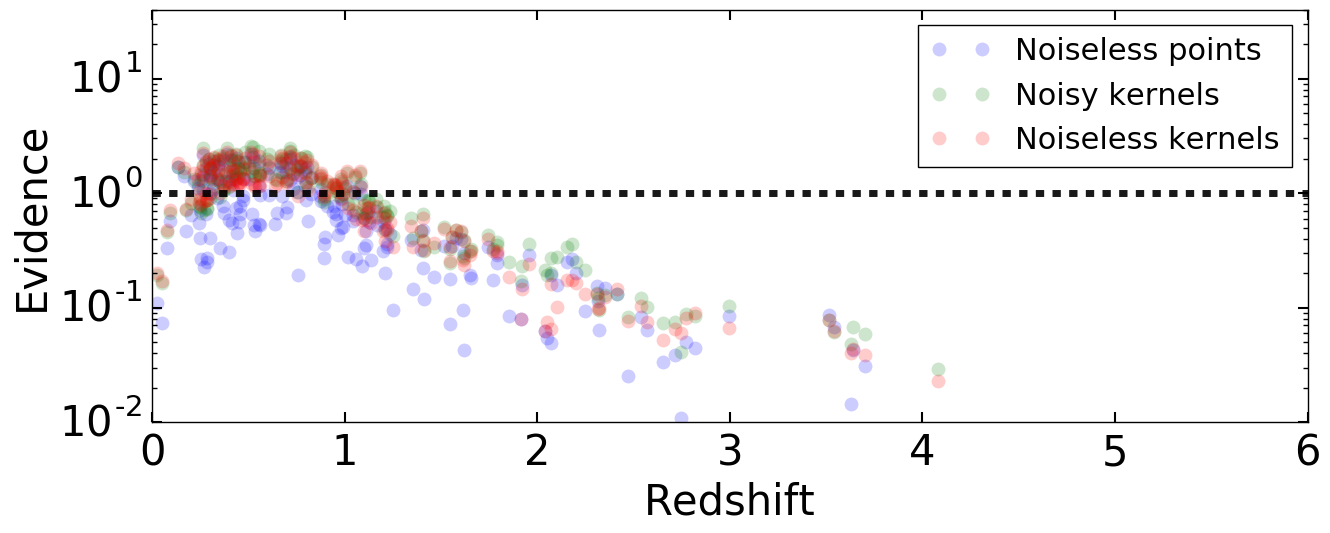

In [21]:
figure(figsize=(14,6))
semilogy(redshifts[::100], znorm[::100]*dz, 'o', markersize=10, alpha=0.2, label='Noiseless points', markeredgecolor='none')
semilogy(redshifts[::100], znorm2[::100]*dz, 'o', markersize=10, alpha=0.2, label='Noisy kernels', markeredgecolor='none')
semilogy(redshifts[::100], znorm3[::100]*dz, 'o', markersize=10, alpha=0.2, label='Noiseless kernels', markeredgecolor='none')
plot([0,6], [1, 1], color='black', lw=5, alpha=0.9, ls='--')
xlabel('Redshift')
ylim([None, 40])
ylabel('Evidence')
legend(fontsize=22, loc=1)
tight_layout()

As expected, this distribution traces the underlying redshift distribution (since we've sampled from the underlying redshift distribution), and we can see that in both cases several observed objects do not have enough coverage for our predictions be considered "reliable".

## Population Modeling

We now want to derive *errors* around our $N(z|\mathbf{g})$ predictions from our underlying PDFs. In particular, we want to generate a series of posterior $N(z|\mathbf{g})$ samples.

To start, we're going to go back to our model grid over our point process since inference is more intuitive in that domain.

In [22]:
Nsamples = 20 # number of dN/dz samples

### Poisson

A common approximation is that the number of objects in each redshift bin are independent of each other and simply a counting (Poisson) process. The number of objects in each bin then follows a **Poisson distribution**

$$
\hat{N}_h \sim \textrm{Pois}(N|\lambda_h = N(z_h|\mathbf{g}))
$$

where $\lambda_h$ is the associated concentration parameter. The mean and covariance of our random vector $\hat{N}(\mathbf{z}|\mathbf{g})$ is then

$$
\boldsymbol{\mu} = N(\mathbf{z}|\mathbf{g}) \quad , \quad \mathbf{C} = \textrm{diag}(N(\mathbf{z}|\mathbf{g}))
$$

where $\textrm{diag}(\cdots)$ is the diagonal matrix operator.

In [23]:
pdf1 = zpdf.sum(axis=0) # stacked PDF
pdf1 /= pdf1.sum() # normalize
pdf1 *= Nobs # sample size
pdf1_samples = array([poisson(pdf1) for i in xrange(Nsamples)]) # samples

What exactly does this imply? It's hard to say. One clear issue is that there's no sensical meaning of a PDF here: we're just simply counting up the number of galaxies in each redshift bin, and we assume that the number $N_h$ we've counted is actually the mean. Furthermore, our assumption of independence isn't really right here, since our redshift bins aren't fully independent (since objects have some intrinsic PDF). Most importantly, however, this approximation implies that the total number of objects we observe doesn't remain constant! 

All that said, let's see how our results look.

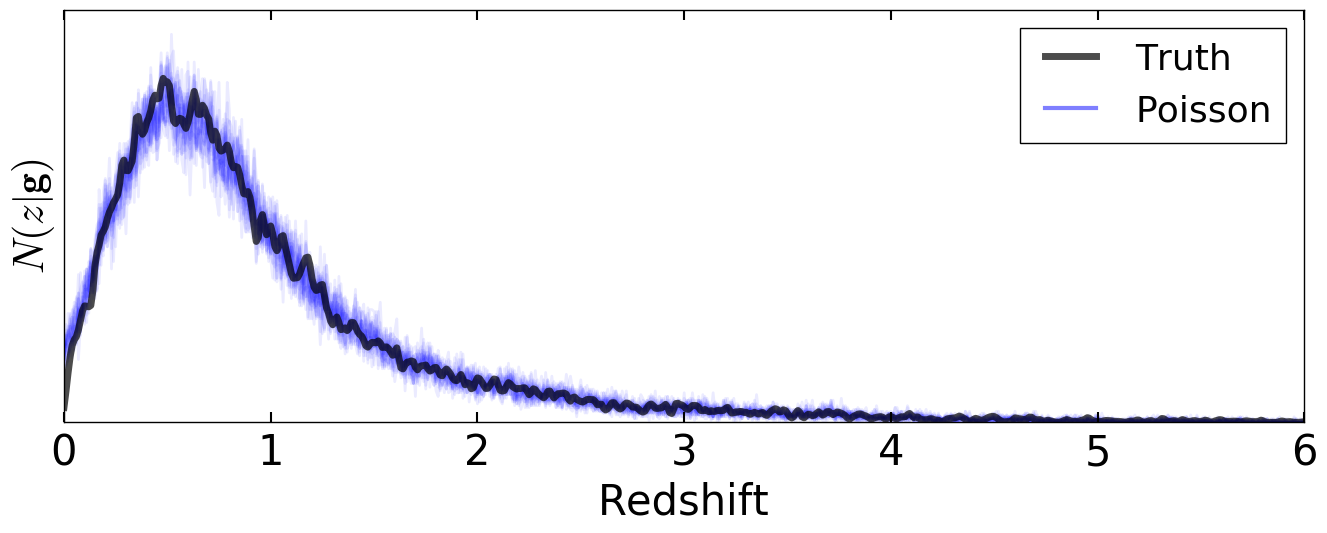

In [25]:
# plotting
figure(figsize=(14,6))
[plot(zgrid, pdf1_samples[i], lw=2, color='blue', alpha=0.08) for i in xrange(Nsamples)]
plot(zgrid, pdf/pdf.sum() * Nobs, lw=5, color='black', alpha=0.7, label='Truth')
plot(zgrid, pdf*0.0-1e4, lw=3, color='blue', alpha=0.5, label='Poisson')
xlabel('Redshift')
yticks([])
ylim([0, max(pdf/pdf.sum() * Nobs) * 1.2])
ylabel('$N(z|\mathbf{g})$')
legend(fontsize=26, loc='best')
tight_layout()

Given our previous concerns, that looks reasonable overall.

### Multinomial

One improvement on the Poisson is to assume our observed $N(\mathbf{z}|\mathbf{g})$ is drawn from the **Multinomial distribution** such that

$$
\hat{N}(\mathbf{z}|\mathbf{g}) \sim \textrm{Mult}(n = N_g, \mathbf{p} = N(\mathbf{z}|\mathbf{g})/N_g)
$$

where $n$ is the number of draws and $\mathbf{p}$ is the probability of associated with our $N_h$ categories (in this case our redshift grid points). 

What's the intuition for this form? This implies that the PDF of a random observed galaxy $g$ is proportional to the observed $N(z|\mathbf{g})$. The Multinomial has the benefit of keeping the overall number of galaxies constant, and in doing so induces correlations among the individual categories (redshift points). However, given the fact that galaxies don't all have the same PDF, the correlations this will induce among our redshift bins will likely be off.

The mean and covariance of our random vector $\hat{N}(\mathbf{z}|\mathbf{g})$ is now

$$
\boldsymbol{\mu} = n\mathbf{p} = N(\mathbf{z}|\mathbf{g}) \quad , \quad \mathbf{C} = n(\textrm{diag}(\mathbf{p}) - \mathbf{p}\mathbf{p}^T) = \textrm{diag}(N(\mathbf{z}|\mathbf{g})) - [N(\mathbf{z}|\mathbf{g})][N(\mathbf{z}|\mathbf{g})]^T/N_g  \quad ,
$$

which we can see is equivalent to our original Poisson approximation with the addition of new off-diagonal (anti-)covariances (which remove some power from the diagonal elements). This is just the formalized version of the intuition that as we add more galaxies to a particular redshift then we have to take away galaxies from another redshift to keep the total number constant.

In [26]:
pdf2_samples = multinomial(Nobs, pdf1/pdf1.sum(), size=Nsamples) # samples

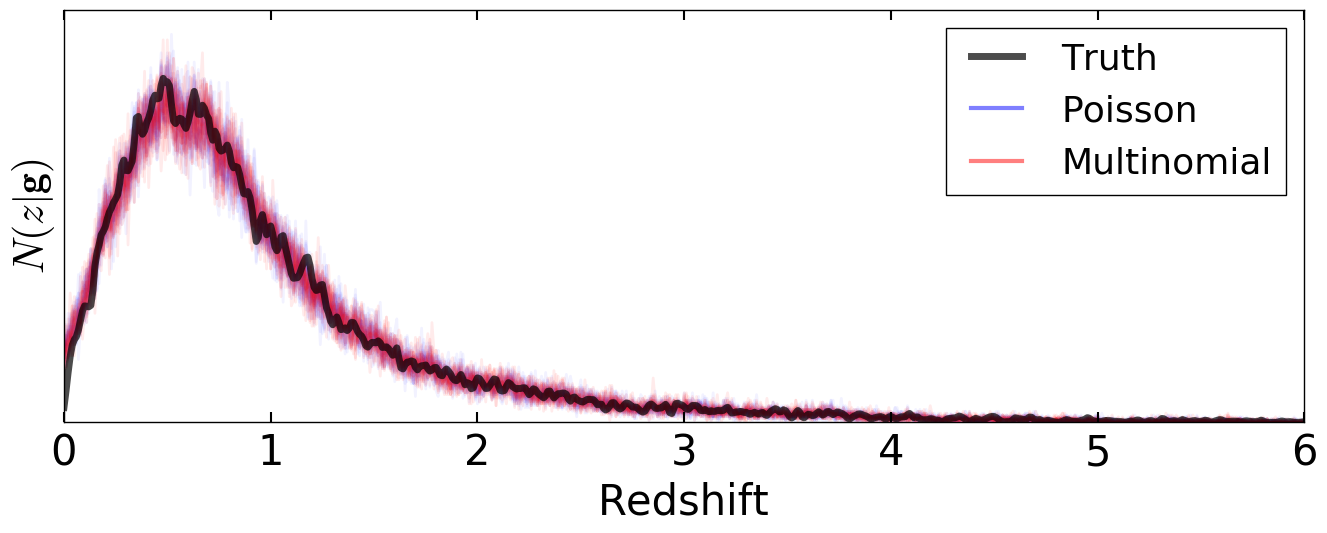

In [27]:
# plotting
figure(figsize=(14,6))
[plot(zgrid, pdf1_samples[i], lw=2, color='blue', alpha=0.05) for i in xrange(Nsamples)]
[plot(zgrid, pdf2_samples[i], lw=2, color='red', alpha=0.08) for i in xrange(Nsamples)]
plot(zgrid, pdf/pdf.sum() * Nobs, lw=5, color='black', alpha=0.7, label='Truth')
plot(zgrid, pdf*0.0-1e4, lw=3, color='blue', alpha=0.5, label='Poisson')
plot(zgrid, pdf*0.0-1e4, lw=3, color='red', alpha=0.5, label='Multinomial')
xlabel('Redshift')
yticks([])
ylim([0, max(pdf/pdf.sum() * Nobs) * 1.2])
ylabel('$N(z|\mathbf{g})$')
legend(fontsize=26, loc='best')
tight_layout()

### Posterior

Any particular galaxy $g$ with PDF $P(z\mathbf{z}|g)$ is fundamentally located at a particular redshift $z_g$ -- the corresponding redshift PDF simply illustrates our uncertainty over its true location. We can treat $z_g$ as a **random variable** which is distributed as

$$
z_g \sim \textrm{Mult} \left(n=1, \mathbf{p}=\mathbf{p}_g \right)
$$

over our redshift bins $\mathbf{z}$ where $\mathbf{p}_g \equiv P(\mathbf{z}|g)$. The redshift number density $\mathbf{n} \equiv N(\mathbf{z}|\mathbf{g})$ is then

$$
\mathbf{n} \sim \sum_{g \in \mathbf{g}} \textrm{Mult} \left(n=1, \mathbf{p}=\mathbf{p}_g \right) \quad .
$$

This represents a convolution of a series of Multinomial-distributed random variables with different PDFs. While $\mathbf{n}$ here has the same mean $\boldsymbol{\mu}$ as the previous two distributions, the covariance $\mathbf{C}$ is much more complicated and cannot be written down analytically.

As above, it is straightforward to draw samples $\mathbf{n}^{(i)}$ from this distribution by iteratively sampling from the underlying PDFs and then stacking the results.

In [28]:
pdf3_samples = zeros(pdf1_samples.shape)
for j in xrange(Nsamples):
    sys.stdout.write(str(j)+' ')
    for i in xrange(Nobs):
        pdf3_samples[j] += multinomial(1, zpdf[i]/zpdf[i].sum()) # stack multinomial draw

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

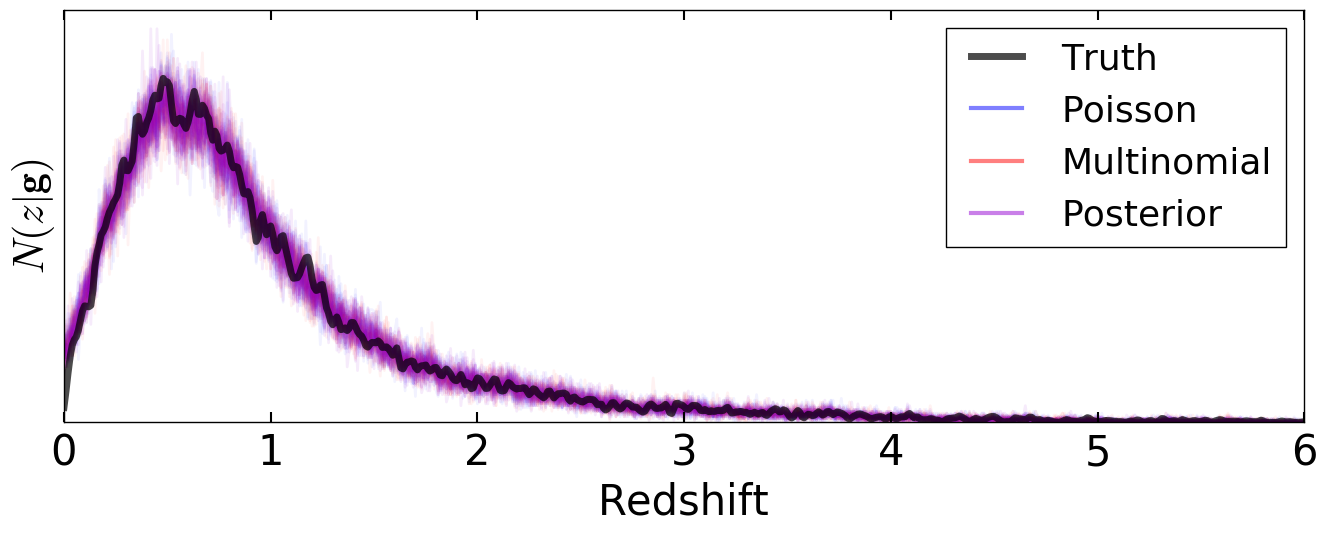

In [29]:
# plotting
figure(figsize=(14,6))
[plot(zgrid, pdf1_samples[i], lw=2, color='blue', alpha=0.05) for i in xrange(Nsamples)]
[plot(zgrid, pdf2_samples[i], lw=2, color='red', alpha=0.05) for i in xrange(Nsamples)]
[plot(zgrid, pdf3_samples[i], lw=2, color='darkviolet', alpha=0.08) for i in xrange(Nsamples)]
plot(zgrid, pdf/pdf.sum() * Nobs, lw=5, color='black', alpha=0.7, label='Truth')
plot(zgrid, pdf*0.0-1e4, lw=3, color='blue', alpha=0.5, label='Poisson')
plot(zgrid, pdf*0.0-1e4, lw=3, color='red', alpha=0.5, label='Multinomial')
plot(zgrid, pdf*0.0-1e4, lw=3, color='darkviolet', alpha=0.5, label='Posterior')
xlabel('Redshift')
yticks([])
ylim([0, max(pdf/pdf.sum() * Nobs) * 1.2])
ylabel('$N(z|\mathbf{g})$')
legend(fontsize=26, loc='best')
tight_layout()

## Hierarchical Bayesian Modeling

Given a probability vector $\mathbf{p}$, an individual galaxy $z_g$ is distributed as $z_g \sim \textrm{Mult}\left[1, \mathbf{p}\right]$. However, given a dataset with $N$ objects with corresponding number densities $\mathbf{n}$ across our $N_p$ categories that we use to estimate $\mathbf{p}$, our probability vector $\mathbf{p}$ can be shown (Speagle et al. 2017) to be distributed as 

$$ 
\mathbf{p} \sim \textrm{Dir}\left(\mathbf{p} | \boldsymbol{\alpha} = \mathbf{n}+1 \right)
$$

where $\textrm{Dir}\left(\mathbf{p}|\boldsymbol{\alpha}\right)$ is the **Dirichlet distribution** with concentration parameter $\boldsymbol{\alpha}$ across our $N_h$ categories. In general, this tends to upweight our tails and downweight the peak.

We now define a set of redshift **population weights** $\mathbf{w}$ corresponding to our redshift bins $\mathbf{z}$ whose posterior distribution is

$$
\mathbf{w} \sim \textrm{Dir}\left(\mathbf{w} | \boldsymbol{\alpha} = \mathbf{n}+1 \right), \quad \mathbf{n} \sim \sum_{g \in \mathbf{g}} \textrm{Mult} \left(n=1, \mathbf{p}=\mathbf{p}_g \right) \quad .
$$

These weights essentially serve as a type of population-driven prior over our data (which we've previous assume has been fixed). Since we don't know what these are *a priori*, we want to sample them jointly along with our observed number densities. In other words, rather than sampling from $P(\mathbf{w}|\lbrace \dots, \mathbf{p}_g, \dots \rbrace)$, we want to sample from the **joint distribution** $P(\mathbf{w}, \lbrace \dots, \mathbf{p}_g, \dots \rbrace)$, where $\mathbf{w}$ depends on our $\mathbf{p}_g$'s through $\mathbf{n}$.

### Sampling the Joint Distribution

How do we sample from such a distribution? In general, our model is intractable for typical Metropolis-style **Markov Chain Monte Carlo (MCMC)** rejection samplers that try and probe the $(N_h + N_g)$-parameter joint distribution directly. 

It is, however, particularly amenable to **Gibbs sampling**, which samples from joint distribution by iteratively sampling from the associated conditional distributions. In this case, this means we sample iteratively from $P(\lbrace \dots, \mathbf{p}_g, \dots \rbrace | \mathbf{w})$ and $P(\mathbf{w} | \lbrace \dots, \mathbf{p}_g, \dots \rbrace)$. Assuming **Poisson independence** for all $g \in \mathbf{g}$, we can draw our samples from our joint posterior via

\begin{align}
\textrm{Sample individual redshifts:}& \quad \lbrace \dots, \mathbf{\hat{p}}_g^{(i)}, \dots \rbrace \sim \left\lbrace \dots, \textrm{Mult}\left( n=1, \mathbf{p}=\mathbf{p}_g \bullet \mathbf{w}^{(i-1)} \right), \dots \right\rbrace \\
\textrm{Compute number density:}& \quad \mathbf{n}^{(i)} = \sum_{g \in \mathbf{g}} \mathbf{\hat{p}}_g^{(i)} \\
\textrm{Sample population weights:}& \quad \mathbf{w}^{(i)} \sim \textrm{Dir}\left(\mathbf{w} | \mathbf{n}^{(i)} + 1\right) \quad ,
\end{align}

where $\bullet$ indicates the **Hadamard product** (i.e. element-wise multiplication).

In [30]:
# generate samples
Nmcmc = 1000 # total number of MCMC draws
pdf4_samples_w, pdf4_samples_n = zeros((Nmcmc, Nz)), zeros((Nmcmc, Nz))

wt = ones(Nz) # initialize weights
for j in xrange(Nmcmc):
    if j%5==0: sys.stdout.write(str(j)+' ')
    pstack = zeros(Nz)
    zpdf_t = zpdf * wt # compute new posterior
    zpdf_t /= zpdf_t.sum(axis=1)[:,None] # normalize
    for i in arange(Nobs):
        pstack += multinomial(1, zpdf_t[i]) # stack multinomial draw
    wt = dirichlet(pstack + 1) * Nobs # sample population weight (for hierarchical prior)
    pdf4_samples_n[j], pdf4_samples_w[j] = pstack.copy(), wt.copy() # store result

0 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180 185 190 195 200 205 210 215 220 225 230 235 240 245 250 255 260 265 270 275 280 285 290 295 300 305 310 315 320 325 330 335 340 345 350 355 360 365 370 375 380 385 390 395 400 405 410 415 420 425 430 435 440 445 450 455 460 465 470 475 480 485 490 495 500 505 510 515 520 525 530 535 540 545 550 555 560 565 570 575 580 585 590 595 600 605 610 615 620 625 630 635 640 645 650 655 660 665 670 675 680 685 690 695 700 705 710 715 720 725 730 735 740 745 750 755 760 765 770 775 780 785 790 795 800 805 810 815 820 825 830 835 840 845 850 855 860 865 870 875 880 885 890 895 900 905 910 915 920 925 930 935 940 945 950 955 960 965 970 975 980 985 990 995 

As with any MCMC sampler, we need time to "burn in" to the stationary distribution and often some subsequent thinning of the to ensure more independent samples. We check both of these conditions below by looking at the autocorrelation time for a few of our redshift grid points, the general autocorrelation for $\Delta t=1$, and a few traces of our samples.

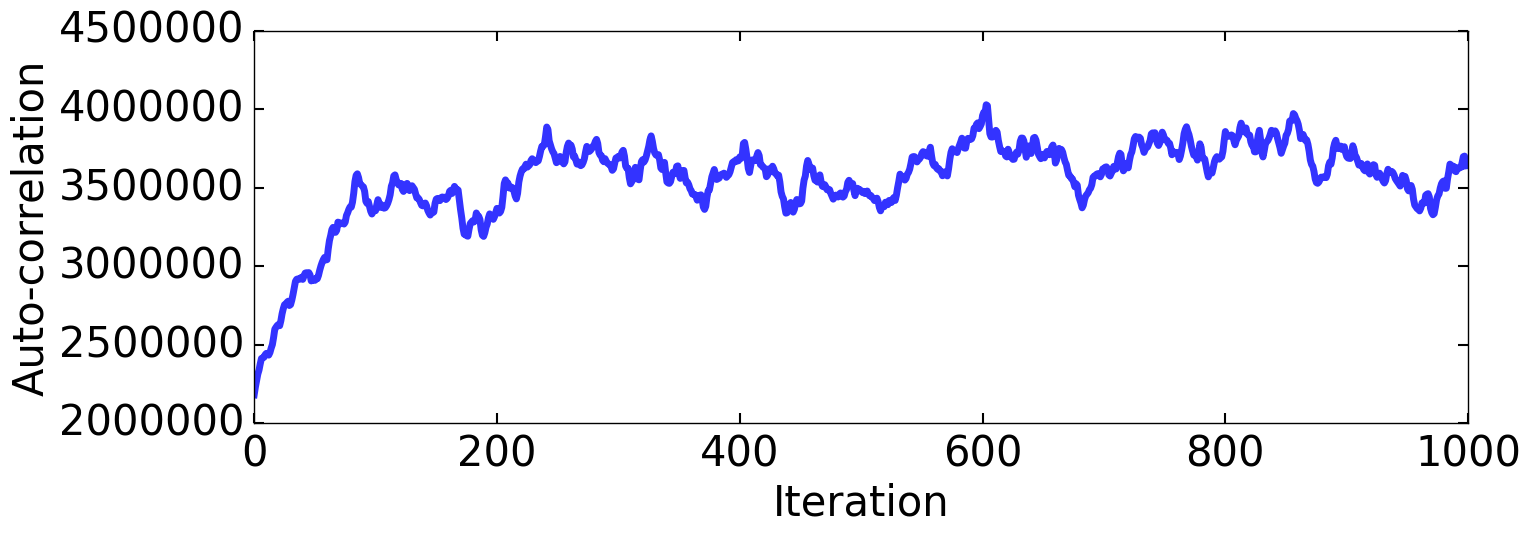

In [31]:
# plot lag=1 autocorrelation
figure(figsize=(16,6))
autocorr = array([correlate(pdf4_samples_n[i], pdf4_samples_n[i+1]) for i in arange(Nmcmc-1)]).flatten()
plot(arange(Nmcmc-1), autocorr, lw=5, color='blue', alpha=0.8)
xlabel('Iteration')
ylabel('Auto-correlation')
xlim([0, Nmcmc])
tight_layout()

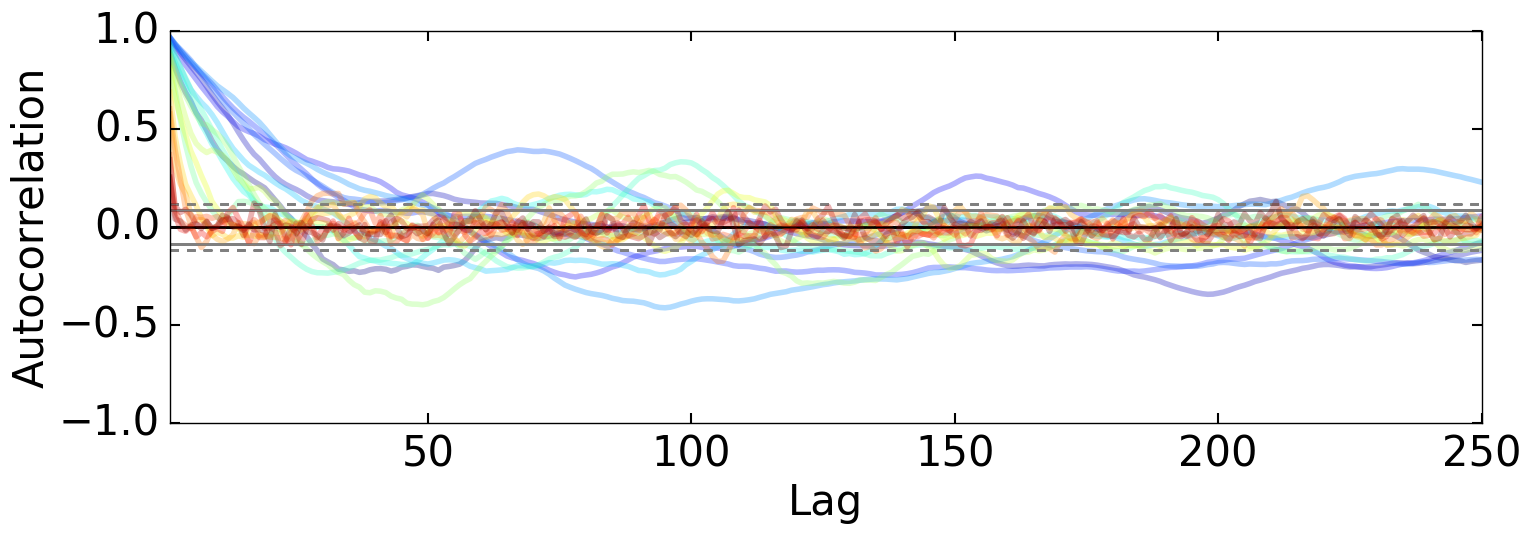

In [32]:
# plot autocorrelation lag
Nburnin = 500
figure(figsize=(16,6))
colors=get_cmap('jet')(linspace(0,1,20))
h = [autocorrelation_plot(pdf4_samples_n[Nburnin:,i*(Nz/20)], color=colors[i], lw=4, alpha=0.3) for i in xrange(20)]
xlim([1, (Nmcmc-Nburnin)/2])
tight_layout()

Let's pick a compromise length scale to thin our samples by.

In [33]:
# thinning
Nthin = 25
pdf4_samples_t = pdf4_samples_n[Nburnin::Nthin]

Now let's take a look at our final results.

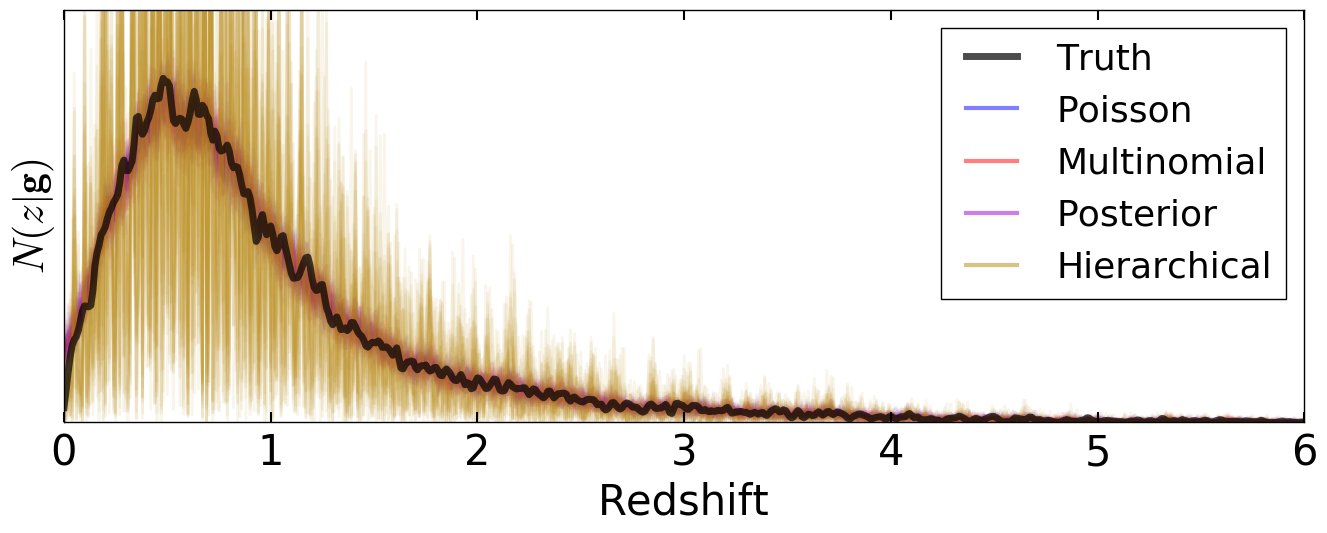

In [34]:
# plotting
figure(figsize=(14,6))
[plot(zgrid, pdf1_samples[i], lw=2, color='blue', alpha=0.05) for i in xrange(Nsamples)]
[plot(zgrid, pdf2_samples[i], lw=2, color='red', alpha=0.05) for i in xrange(Nsamples)]
[plot(zgrid, pdf3_samples[i], lw=2, color='darkviolet', alpha=0.05) for i in xrange(Nsamples)]
[plot(zgrid, pdf4_samples_t[i], lw=2, color='darkgoldenrod', alpha=0.08) for i in xrange(Nsamples)]
plot(zgrid, pdf/pdf.sum() * Nobs, lw=5, color='black', alpha=0.7, label='Truth')
plot(zgrid, pdf*0.0-1e4, lw=3, color='blue', alpha=0.5, label='Poisson')
plot(zgrid, pdf*0.0-1e4, lw=3, color='red', alpha=0.5, label='Multinomial')
plot(zgrid, pdf*0.0-1e4, lw=3, color='darkviolet', alpha=0.5, label='Posterior')
plot(zgrid, pdf*0.0-1e4, lw=3, color='darkgoldenrod', alpha=0.5, label='Hierarchical')
xlabel('Redshift')
yticks([])
ylim([0, max(pdf/pdf.sum() * Nobs) * 1.2])
ylabel('$N(z|\mathbf{g})$')
legend(fontsize=26, loc='best')
tight_layout()

Our hierarchical sample appears to experience some enourmous variation! There are a few primary reasons for this. Most crucially, our Dirichlet distribution is fundamentally an unordered distribution. By disregarding the fact that the amplitude of nearby redshift bins should inherently be strongly correlated with each other, it allows for more (unphysical) variation than might otherwise be possible. In addition, our PDFs are relatively broad compared to the resolution of our redshift grid (encompassing 2-20 bins out of 601), especially given the size of our sample (100k galaxies). This lends itself to a lot of possible sample variation.

These very noisy results, however, still can be leveraged to give good predictions at coarser resolutions, as shown below.

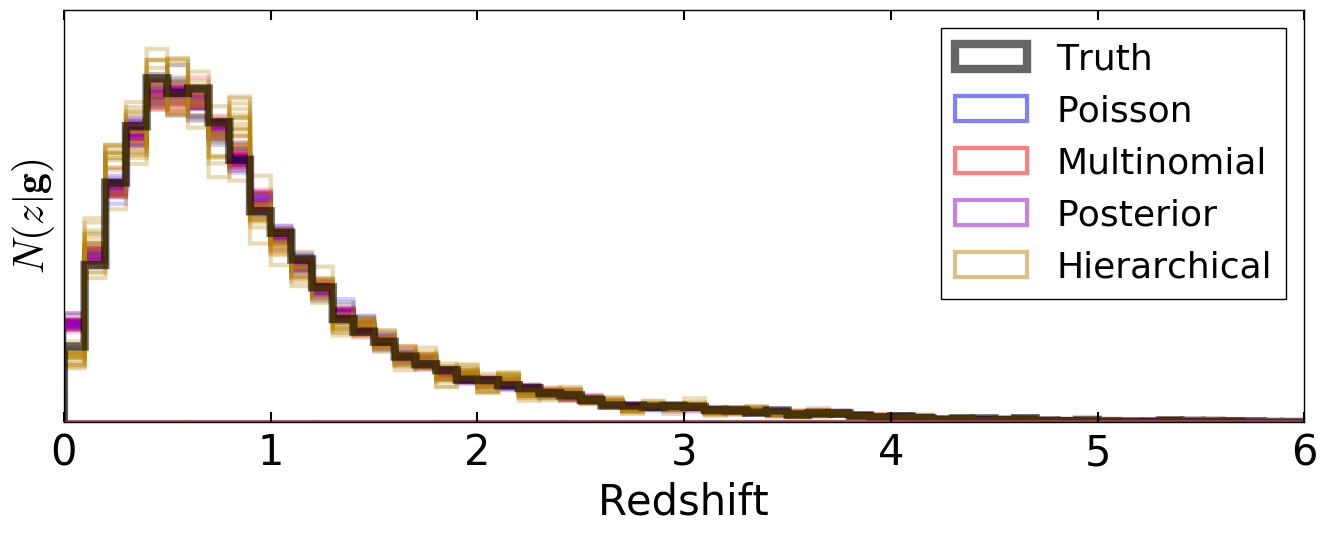

In [35]:
# plotting binned results
figure(figsize=(14,6))
[hist(zgrid, zgrid[::10], weights=pdf1_samples[i], lw=3, histtype='step', color='blue', alpha=0.2) 
 for i in xrange(Nsamples)]
[hist(zgrid, zgrid[::10], weights=pdf2_samples[i], lw=3, histtype='step', color='red', alpha=0.2) 
 for i in xrange(Nsamples)]
[hist(zgrid, zgrid[::10], weights=pdf3_samples[i], lw=3, histtype='step', color='darkviolet', alpha=0.2) 
 for i in xrange(Nsamples)]
[hist(zgrid, zgrid[::10], weights=pdf4_samples_t[i], lw=3, histtype='step', color='darkgoldenrod', alpha=0.3) 
 for i in xrange(Nsamples)]
h = hist(zgrid, zgrid[::10], weights = pdf/pdf.sum() * Nobs, histtype='step', 
         lw=6, color='black', alpha=0.6, label='Truth')
hist(zgrid, weights=pdf*1e-5, lw=3, histtype='step', color='blue', alpha=0.5, label='Poisson')
hist(zgrid, weights=pdf*1e-5, lw=3, histtype='step', color='red', alpha=0.5, label='Multinomial')
hist(zgrid, weights=pdf*1e-5, lw=3, histtype='step', color='darkviolet', alpha=0.5, label='Posterior')
hist(zgrid, weights=pdf*1e-5, lw=3, histtype='step', color='darkgoldenrod', alpha=0.5, label='Hierarchical')
xlabel('Redshift')
yticks([])
ylim([0, max(h[0]) * 1.2])
ylabel('$N(z|\mathbf{g})$')
legend(fontsize=26, loc='best')
tight_layout()

Only our hierarchical model is able to properly recover the true underlying distribution at the low redshift end.

Another way to visualize our results is by looking at the covariances between neighboring redshift bins. We'll just take a look at one here.

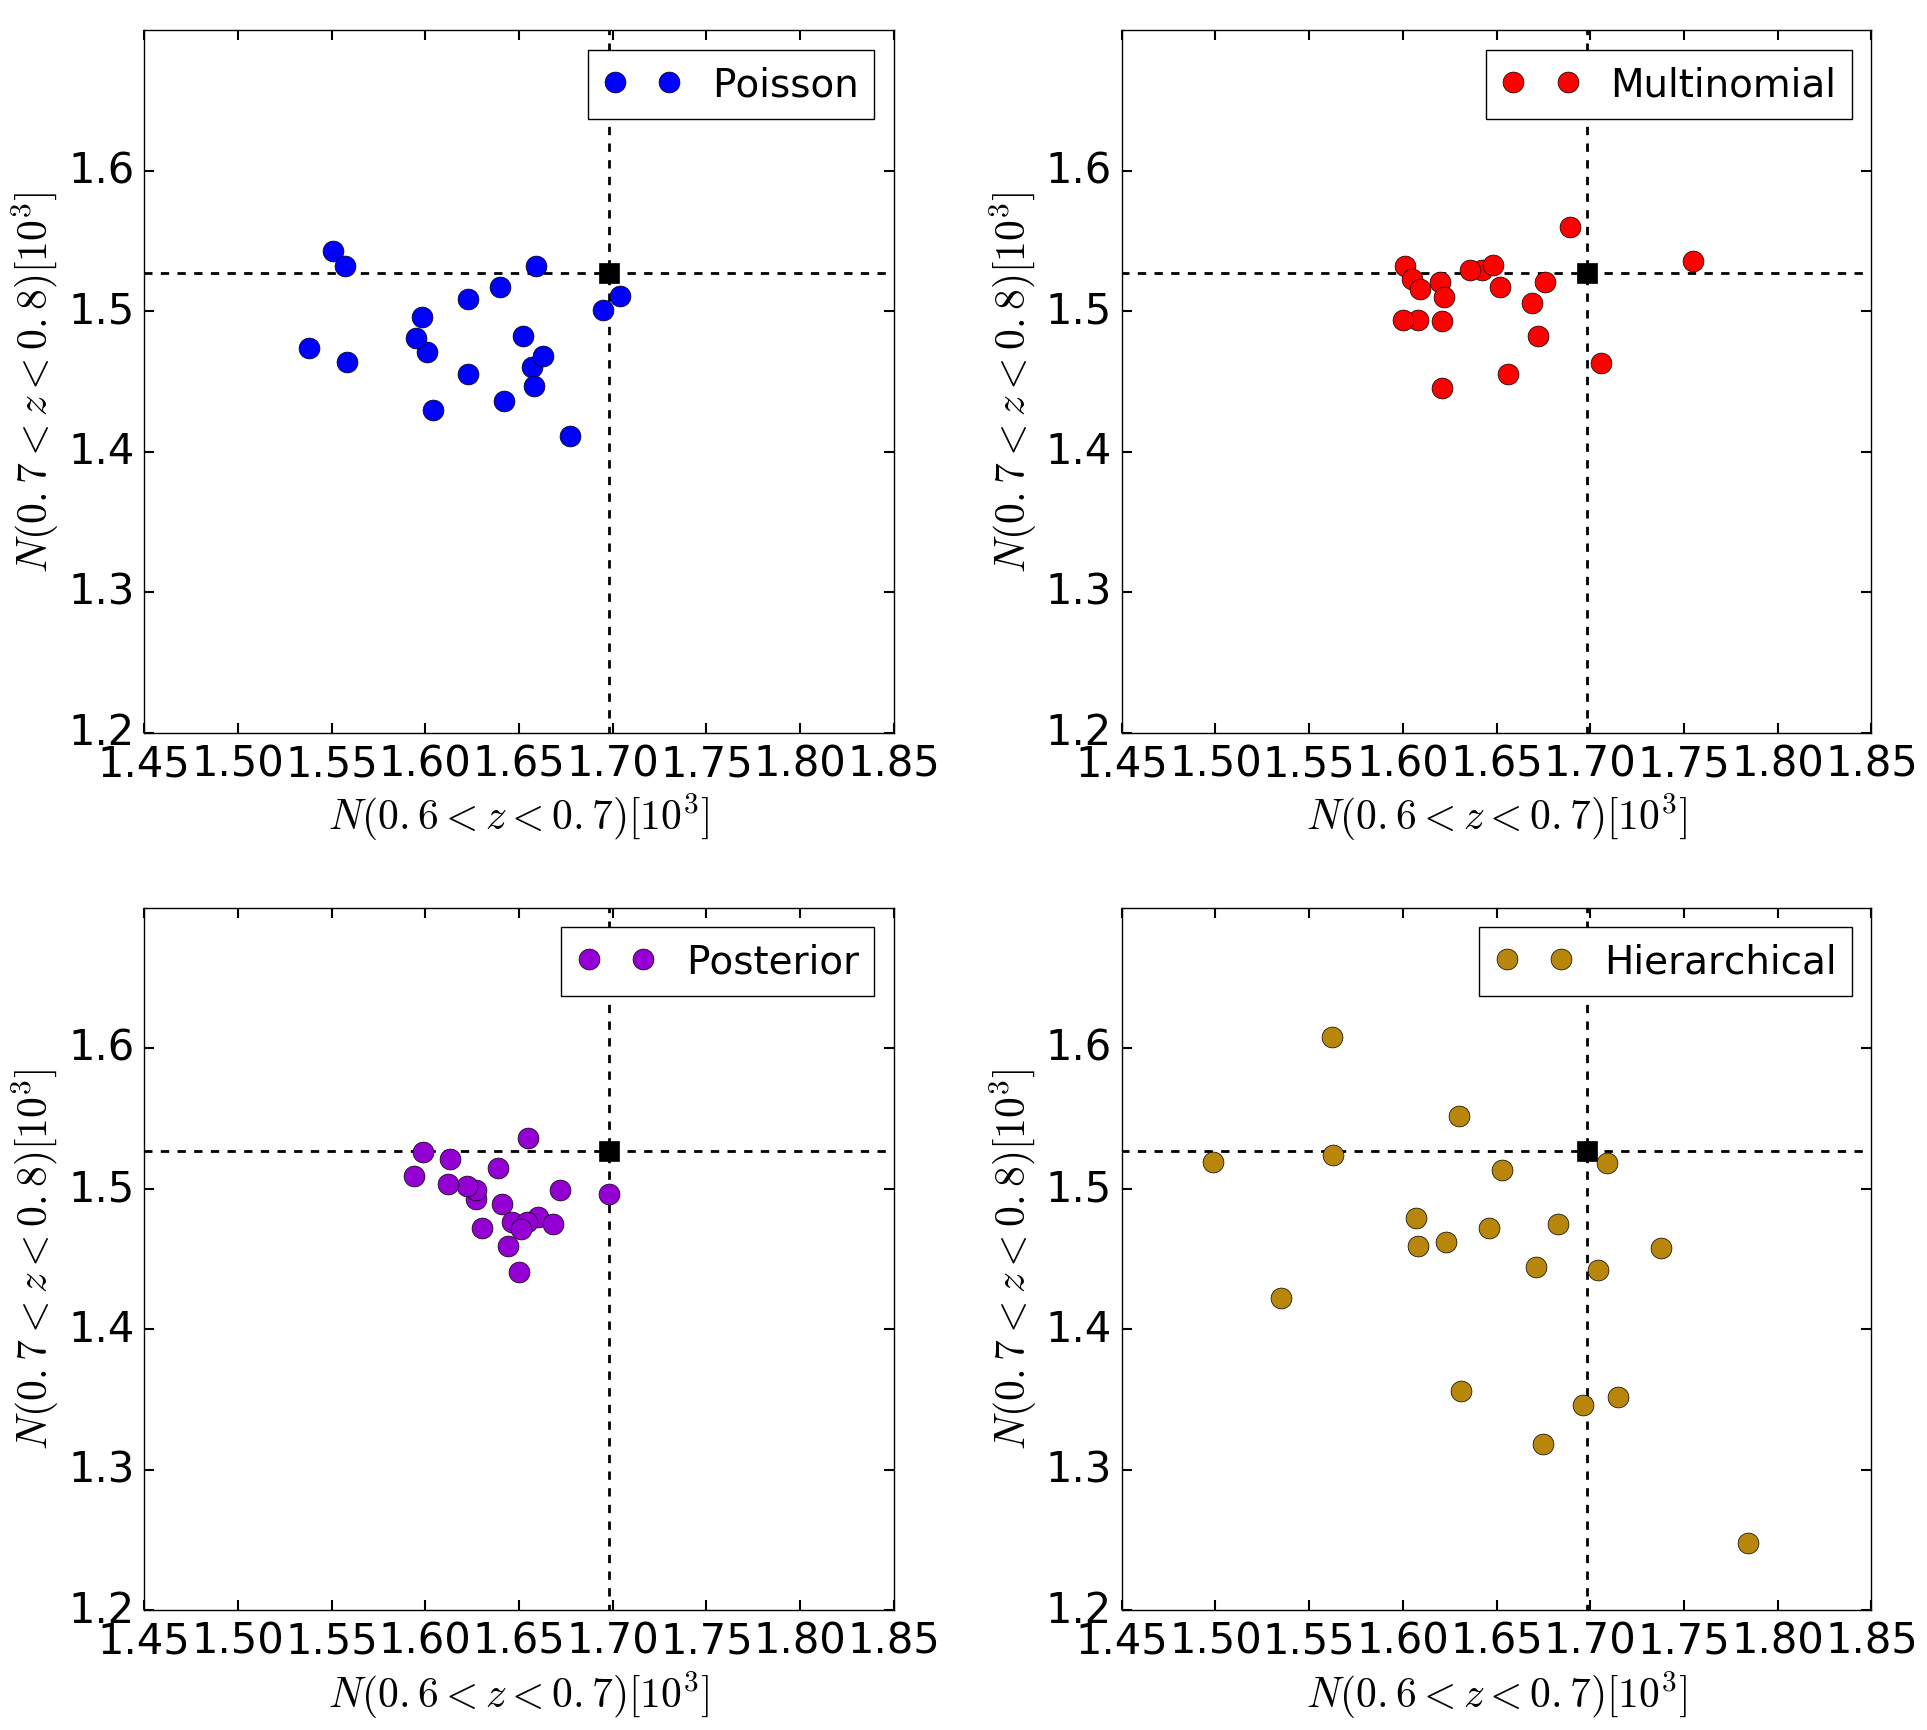

In [37]:
figure(figsize=(20,18))
subplot(2,2,1)
vlines(pdf[60:70].sum()/pdf.sum()*Nobs/1e3, 0, 100, lw=2, colors='black', linestyles='--')
hlines(pdf[70:80].sum()/pdf.sum()*Nobs/1e3, 0, 100, lw=2, colors='black', linestyles='--')
plot(pdf[60:70].sum()/pdf.sum()*Nobs/1e3, pdf[70:80].sum()/pdf.sum()*Nobs/1e3, 's', color='black', markersize=15)
plot(pdf1_samples[:,60:70].sum(axis=1)/1e3, pdf1_samples[:,70:80].sum(axis=1)/1e3, 'o', color='blue', label='Poisson', 
     markersize=15)
ylim([1.2, 1.7])
xlim([1.45, 1.85])
xlabel('$N(0.6<z<0.7) [10^3]$')
ylabel('$N(0.7<z<0.8) [10^3]$')
legend(fontsize=28, loc=1)
tight_layout()
subplot(2,2,2)
vlines(pdf[60:70].sum()/pdf.sum()*Nobs/1e3, 0, 100, lw=2, colors='black', linestyles='--')
hlines(pdf[70:80].sum()/pdf.sum()*Nobs/1e3, 0, 100, lw=2, colors='black', linestyles='--')
plot(pdf[60:70].sum()/pdf.sum()*Nobs/1e3, pdf[70:80].sum()/pdf.sum()*Nobs/1e3, 's', color='black', markersize=15)
plot(pdf2_samples[:,60:70].sum(axis=1)/1e3, pdf2_samples[:,70:80].sum(axis=1)/1e3, 'o', color='red', label='Multinomial',
     markersize=15)
ylim([1.2, 1.7])
xlim([1.45, 1.85])
xlabel('$N(0.6<z<0.7) [10^3]$')
ylabel('$N(0.7<z<0.8) [10^3]$')
legend(fontsize=28, loc=1)
tight_layout()
subplot(2,2,3)
vlines(pdf[60:70].sum()/pdf.sum()*Nobs/1e3, 0, 100, lw=2, colors='black', linestyles='--')
hlines(pdf[70:80].sum()/pdf.sum()*Nobs/1e3, 0, 100, lw=2, colors='black', linestyles='--')
plot(pdf[60:70].sum()/pdf.sum()*Nobs/1e3, pdf[70:80].sum()/pdf.sum()*Nobs/1e3, 's', color='black', markersize=15)
plot(pdf3_samples[:,60:70].sum(axis=1)/1e3, pdf3_samples[:,70:80].sum(axis=1)/1e3, 'o', color='darkviolet', label='Posterior',
     markersize=15)
ylim([1.2, 1.7])
xlim([1.45, 1.85])
xlabel('$N(0.6<z<0.7) [10^3]$')
ylabel('$N(0.7<z<0.8) [10^3]$')
legend(fontsize=28, loc=1)
tight_layout()
subplot(2,2,4)
vlines(pdf[60:70].sum()/pdf.sum()*Nobs/1e3, 0, 100, lw=2, colors='black', linestyles='--')
hlines(pdf[70:80].sum()/pdf.sum()*Nobs/1e3, 0, 100, lw=2, colors='black', linestyles='--')
plot(pdf[60:70].sum()/pdf.sum()*Nobs/1e3, pdf[70:80].sum()/pdf.sum()*Nobs/1e3, 's', color='black', markersize=15)
plot(pdf4_samples_t[:,60:70].sum(axis=1)/1e3, pdf4_samples_t[:,70:80].sum(axis=1)/1e3, 'o', 
     color='darkgoldenrod', label='Hierarchical', markersize=15)
ylim([1.2, 1.7])
xlim([1.45, 1.85])
xlabel('$N(0.6<z<0.7) [10^3]$')
ylabel('$N(0.7<z<0.8) [10^3]$')
legend(fontsize=28, loc=1)
tight_layout()

Our behavior is as we expect: our Poisson model, which draws samples independently from the population, is not correlated. Our multinomial model is correlated but somewhat diffuse. Our posterior model is also correlated but more concentrated, since objects tend to have narrower PDFs as compared with the full sample. Finally, our hierarchical model is not only offset from our original predictions, but also shows the most variable behavior while retaining strong (anti-)correlations.

## Hierarchical Point Process

We now broaden our model to include an arbitrary basis of training objects with noisy redshift kernels. For simplicity, we use the same sample of training objects from earlier.

In [38]:
# stack results
like = zeros((Nobs, Ntrain))
for i in arange(Nobs):
    if i%20000 == 0: sys.stdout.write(str(i)+' ')
    chi2 = (mu_train - mu[i])**2 / (sigma[i]**2 + var_train)
    chi2min = chi2.min()
    wt = exp(-0.5*(chi2-chi2min))
    like[i] = wt/wt.sum()

0 

Since we now have likelihoods computed over a series of training objects using only our observables, we can now formulate our models directly in the **training data space**. After we draw our set of samples, it is then straightforward to map our results onto our target distribution of choice (i.e. redshift).

In [39]:
# stack likelihoods
lstack = like.sum(axis=0)

In [40]:
# Poisson
train1_samples = array([poisson(lstack) for i in xrange(Nsamples)]) # samples
z1_samples = zeros((Nsamples, Nz))
for i in xrange(Nsamples):
    sys.stdout.write(str(i)+' ')
    zsamps = []
    Nsamps = train1_samples[i].sum()
    for j in xrange(Ntrain):
        for k in xrange(train1_samples[i][j]):
            zsamps.append( normal(mu_train[j], sigma_train[j]) ) # draw redshift samples
    z1_samples[i] = fz.pdf_kde(zsamps, ones(Nsamps)*dz, ones(Nsamps), zgrid, dz, Nsamps, Nz) # KDE
    z1_samples[i] *= (Nsamps / z1_samples[i].sum()) # normalize

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

In [41]:
# Poisson
train2_samples = multinomial(Nobs, lstack/lstack.sum(), size=Nsamples) # draw objects
z2_samples = zeros((Nsamples, Nz))
for i in xrange(Nsamples):
    sys.stdout.write(str(i)+' ')
    zsamps = []
    for j in xrange(Ntrain):
        for k in xrange(train2_samples[i][j]):
            zsamps.append( normal(mu_train[j], sigma_train[j]) ) # draw redshift samples
    z2_samples[i] = fz.pdf_kde(zsamps, ones(Nobs)*dz, ones(Nobs), zgrid, dz, Nobs, Nz) # KDE
    z2_samples[i] *= (Nobs / z2_samples[i].sum()) # normalize

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

In [42]:
# Posterior
train3_samples = zeros(train1_samples.shape, dtype='int')
z3_samples = zeros((Nsamples, Nz))
for i in xrange(Nsamples):
    sys.stdout.write(str(i)+' ')
    zsamps = []
    for j in xrange(Nobs):
        train3_samples[i] += multinomial(1, like[j]) # draw object samples
    for j in xrange(Ntrain):
        for k in xrange(train3_samples[i][j]):
            zsamps.append( normal(mu_train[j], sigma_train[j]) ) # draw redshift samples
    z3_samples[i] = fz.pdf_kde(zsamps, ones(Nobs)*dz, ones(Nobs), zgrid, dz, Nobs, Nz) # KDE
    z3_samples[i] *= (Nobs / z3_samples[i].sum()) # normalize

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

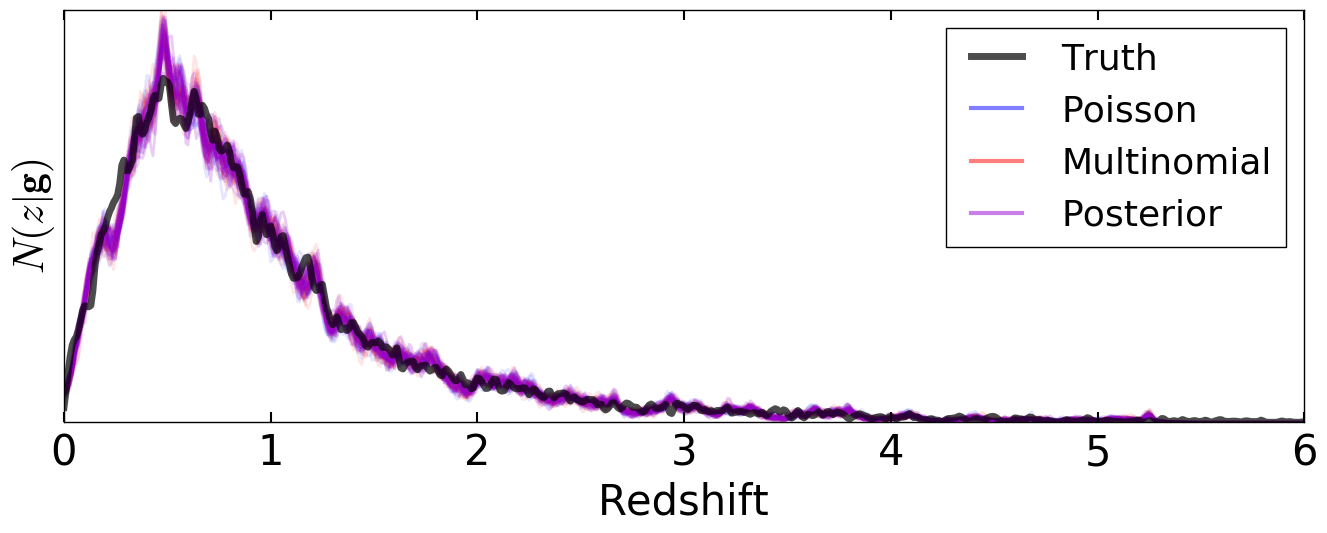

In [44]:
# plotting
figure(figsize=(14,6))
[plot(zgrid, z1_samples[i], lw=2, color='blue', alpha=0.1) for i in xrange(Nsamples)]
[plot(zgrid, z2_samples[i], lw=2, color='red', alpha=0.1) for i in xrange(Nsamples)]
[plot(zgrid, z3_samples[i], lw=2, color='darkviolet', alpha=0.2) for i in xrange(Nsamples)]
plot(zgrid, pdf/pdf.sum() * Nobs, lw=5, color='black', alpha=0.7, label='Truth')
plot(zgrid, pdf*0.0-1e4, lw=3, color='blue', alpha=0.5, label='Poisson')
plot(zgrid, pdf*0.0-1e4, lw=3, color='red', alpha=0.5, label='Multinomial')
plot(zgrid, pdf*0.0-1e4, lw=3, color='darkviolet', alpha=0.5, label='Posterior')
xlabel('Redshift')
yticks([])
ylim([0, max(pdf/pdf.sum() * Nobs) * 1.2])
ylabel('$N(z|\mathbf{g})$')
legend(fontsize=26, loc='best')
tight_layout()

While there is some variation between the draws in both the training object space and the target redshift space, in general our results here give consistent answers with each other up to the (intrinsic) noise introduced by the sampling density of our training set.

How does our hierarchical model do?

In [45]:
# Hierarchical
Nmcmc = 1000 # total number of MCMC draws
train4_samples_n, train4_samples_w = zeros((Nmcmc, Ntrain)), zeros((Nmcmc, Ntrain))

wt = ones(Ntrain) # initialize weights
for i in xrange(Nmcmc):
    if i%5==0: sys.stdout.write(str(i)+' ')
    for j in arange(Nobs):
        like_t = like[j] * wt
        train4_samples_n[i] += multinomial(1, like_t/like_t.sum())
    wt = dirichlet(train4_samples_n[i] + 1) * Nobs # draw population weights
    train4_samples_w[i] = wt.copy() # draw population weights

0 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180 185 190 195 200 205 210 215 220 225 230 235 240 245 250 255 260 265 270 275 280 285 290 295 300 305 310 315 320 325 330 335 340 345 350 355 360 365 370 375 380 385 390 395 400 405 410 415 420 425 430 435 440 445 450 455 460 465 470 475 480 485 490 495 500 505 510 515 520 525 530 535 540 545 550 555 560 565 570 575 580 585 590 595 600 605 610 615 620 625 630 635 640 645 650 655 660 665 670 675 680 685 690 695 700 705 710 715 720 725 730 735 740 745 750 755 760 765 770 775 780 785 790 795 800 805 810 815 820 825 830 835 840 845 850 855 860 865 870 875 880 885 890 895 900 905 910 915 920 925 930 935 940 945 950 955 960 965 970 975 980 985 990 995 

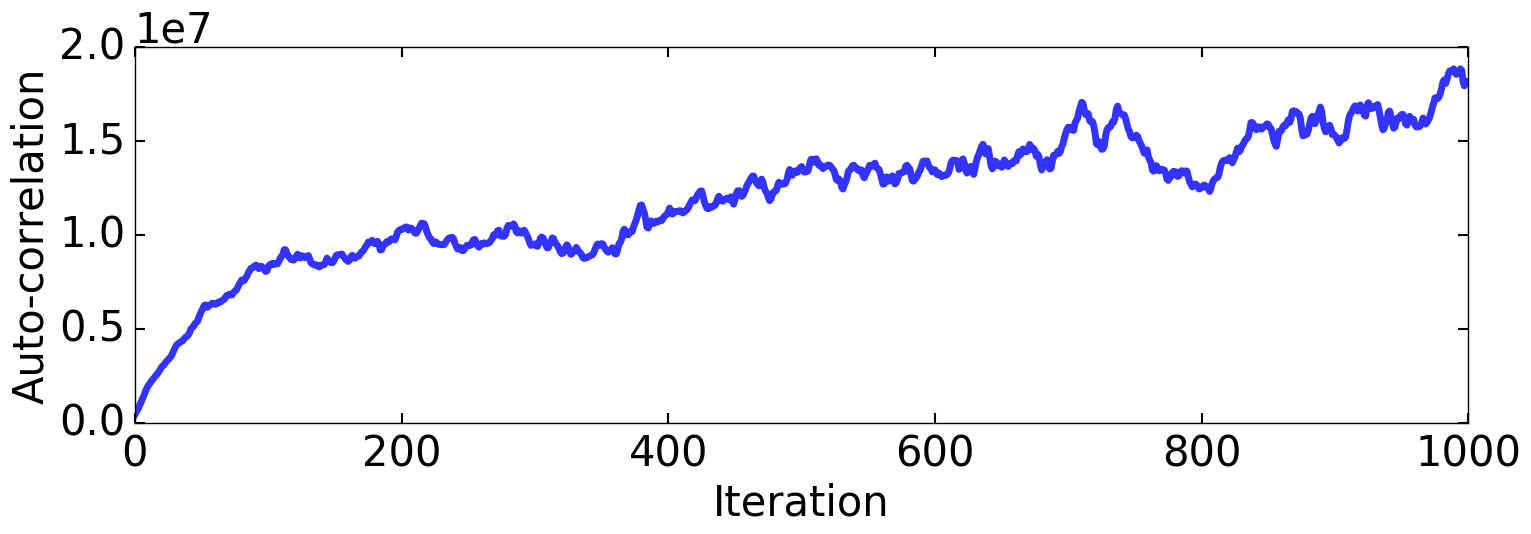

In [46]:
# plot lag=1 autocorrelation
figure(figsize=(16,6))
autocorr = array([correlate(train4_samples_n[i], train4_samples_n[i+1]) for i in arange(Nmcmc-1)]).flatten()
plot(arange(Nmcmc-1), autocorr, lw=5, color='blue', alpha=0.8)
xlabel('Iteration')
ylabel('Auto-correlation')
xlim([0, Nmcmc])
tight_layout()

Now let's examine the traces of the training objects with the largest contributions to the redshift number density after burn-in.

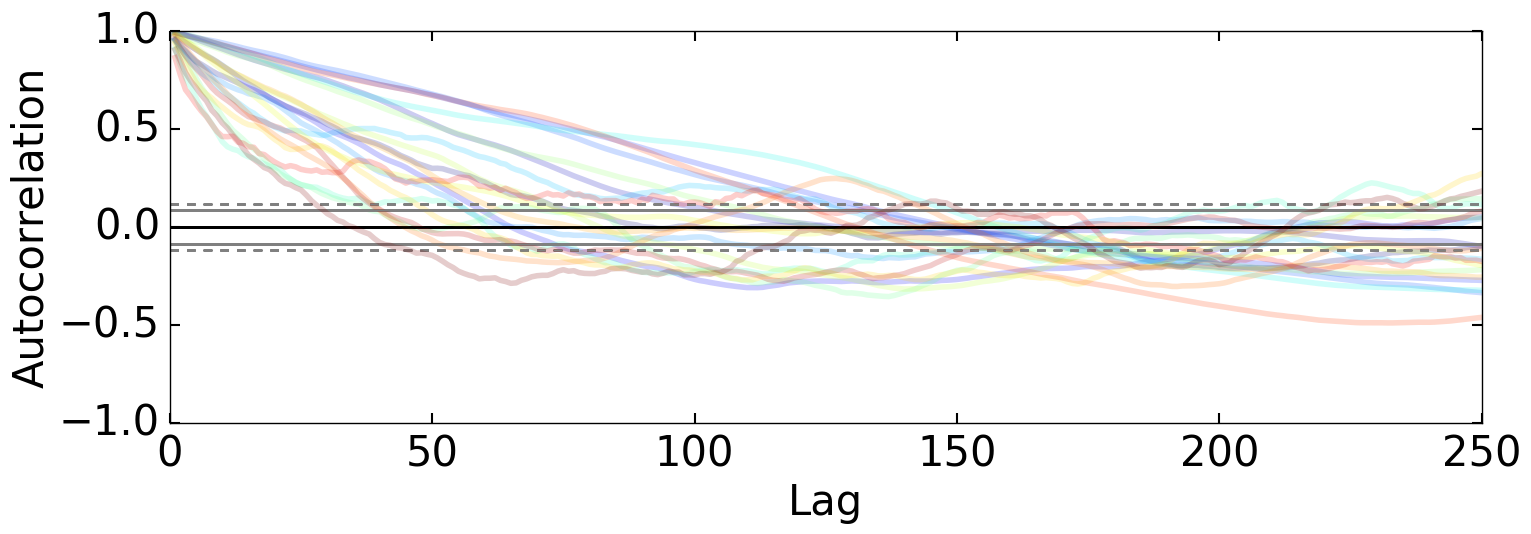

In [47]:
Nburnin = 500 # burn-in
indices = argsort(train4_samples_n[Nburnin:].mean(axis=0))[::-1] # sort from largest to smallest weights

# plot autocorrelation lag
figure(figsize=(16,6))
colors = get_cmap('jet')(linspace(0,1,20))
h = [autocorrelation_plot(train4_samples_n[Nburnin:,indices[i]], color=colors[i], lw=4, alpha=0.2) for i in xrange(20)]
xlim([0, (Nmcmc-Nburnin)/2])
tight_layout()

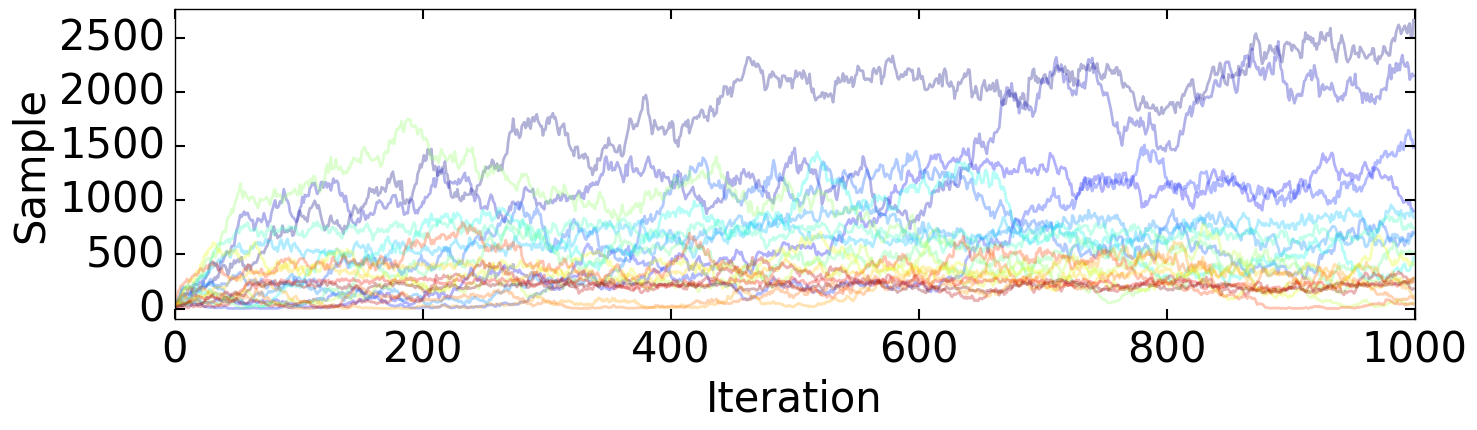

In [48]:
# plot samples
figure(figsize=(16,4))
for i in xrange(20):
    idx = indices[i]
    plot(arange(Nmcmc), train4_samples_n[:,idx], color=colors[i], lw=2, alpha=0.3)
ylim([train4_samples_n[Nburnin:,indices[:20]].min()-100, train4_samples_n[Nburnin:,indices[:20]].max()+100])
xlim([0, Nmcmc])
xlabel('Iteration')
ylabel('Sample')

We notice something interesting here: our hierarchical model is telling us a few objects contribute an extraordinary amount to our final redshift number density $\mathbf{n}$! This is our hierarchical model telling us that our basis is quite redundant and that some objects are much more important than others. This represents a transition away from a prior over number density back to a prior over probability, which illustrates the primary reason why the hierarchical model is so powerful.

In [58]:
Nthin = 25 # thinning
z4_samples_t = zeros((Nsamples, Nz))
for i in arange(Nsamples):
    if i%5==0: sys.stdout.write(str(i)+' ')
    zsamps = []
    tsamps = train4_samples_n[Nburnin::Nthin][i]
    for j in xrange(Ntrain):
        for k in xrange(int(tsamps[j])):
            zsamps.append( normal(mu_train[j], sigma_train[j]) ) # draw redshift samples
    z4_samples_t[i] = fz.pdf_kde(zsamps, ones(Nobs)*dz, ones(Nobs), zgrid, dz, Nobs, Nz) # KDE
    z4_samples_t[i] *= (Nobs / z4_samples_t[i].sum()) # normalize

0 5 10 15 

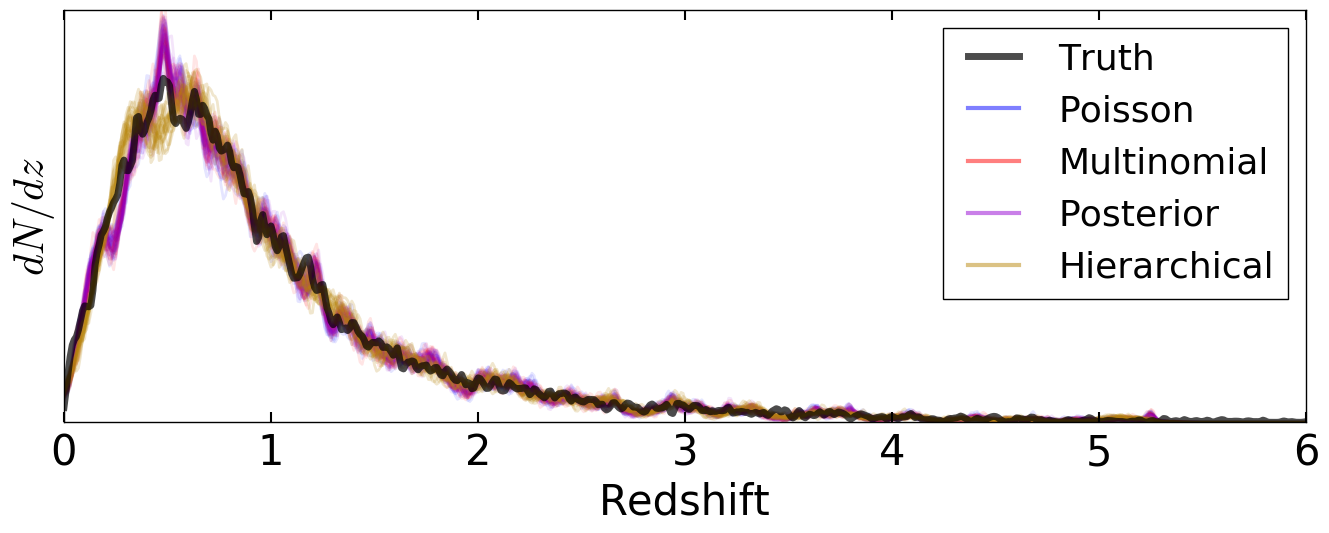

In [59]:
# plotting
figure(figsize=(14,6))
[plot(zgrid, z1_samples[i], lw=2, color='blue', alpha=0.1) for i in xrange(Nsamples)]
[plot(zgrid, z2_samples[i], lw=2, color='red', alpha=0.1) for i in xrange(Nsamples)]
[plot(zgrid, z3_samples[i], lw=2, color='darkviolet', alpha=0.1) for i in xrange(Nsamples)]
[plot(zgrid, z4_samples_t[i], lw=2, color='darkgoldenrod', alpha=0.2) for i in xrange(Nsamples)]
plot(zgrid, pdf/pdf.sum() * Nobs, lw=5, color='black', alpha=0.7, label='Truth')
plot(zgrid, pdf*0.0-1e4, lw=3, color='blue', alpha=0.5, label='Poisson')
plot(zgrid, pdf*0.0-1e4, lw=3, color='red', alpha=0.5, label='Multinomial')
plot(zgrid, pdf*0.0-1e4, lw=3, color='darkviolet', alpha=0.5, label='Posterior')
plot(zgrid, pdf*0.0-1e4, lw=3, color='darkgoldenrod', alpha=0.5, label='Hierarchical')
xlabel('Redshift')
yticks([])
ylim([0, max(pdf/pdf.sum() * Nobs) * 1.2])
ylabel('$dN/dz$')
legend(fontsize=26, loc='best')
tight_layout()

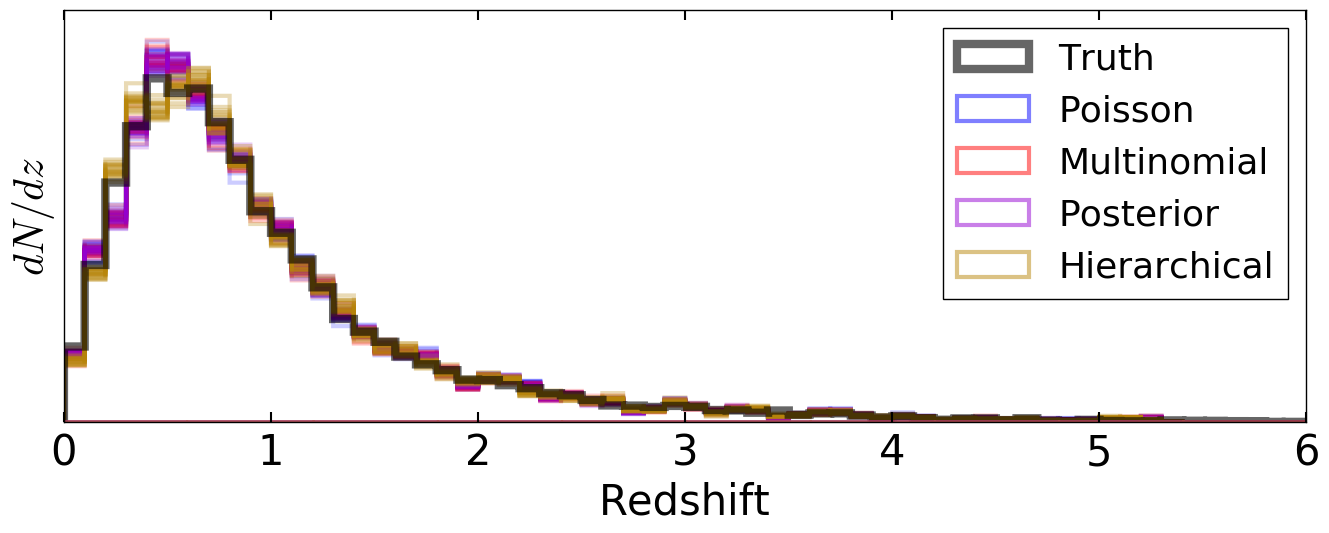

In [60]:
# plotting binned results
figure(figsize=(14,6))
[hist(zgrid, zgrid[::10], weights=z1_samples[i], lw=3, histtype='step', color='blue', alpha=0.2) 
 for i in xrange(Nsamples)]
[hist(zgrid, zgrid[::10], weights=z2_samples[i], lw=3, histtype='step', color='red', alpha=0.2) 
 for i in xrange(Nsamples)]
[hist(zgrid, zgrid[::10], weights=z3_samples[i], lw=3, histtype='step', color='darkviolet', alpha=0.2) 
 for i in xrange(Nsamples)]
[hist(zgrid, zgrid[::10], weights=z4_samples_t[i], lw=3, histtype='step', color='darkgoldenrod', alpha=0.3) 
 for i in xrange(Nsamples)]
h = hist(zgrid, zgrid[::10], weights = pdf/pdf.sum() * Nobs, histtype='step', 
         lw=6, color='black', alpha=0.6, label='Truth')
hist(zgrid, weights=pdf*1e-5, lw=3, histtype='step', color='blue', alpha=0.5, label='Poisson')
hist(zgrid, weights=pdf*1e-5, lw=3, histtype='step', color='red', alpha=0.5, label='Multinomial')
hist(zgrid, weights=pdf*1e-5, lw=3, histtype='step', color='darkviolet', alpha=0.5, label='Posterior')
hist(zgrid, weights=pdf*1e-5, lw=3, histtype='step', color='darkgoldenrod', alpha=0.5, label='Hierarchical')
xlabel('Redshift')
yticks([])
ylim([0, max(h[0]) * 1.2])
ylabel('$dN/dz$')
legend(fontsize=26, loc='best')
tight_layout()

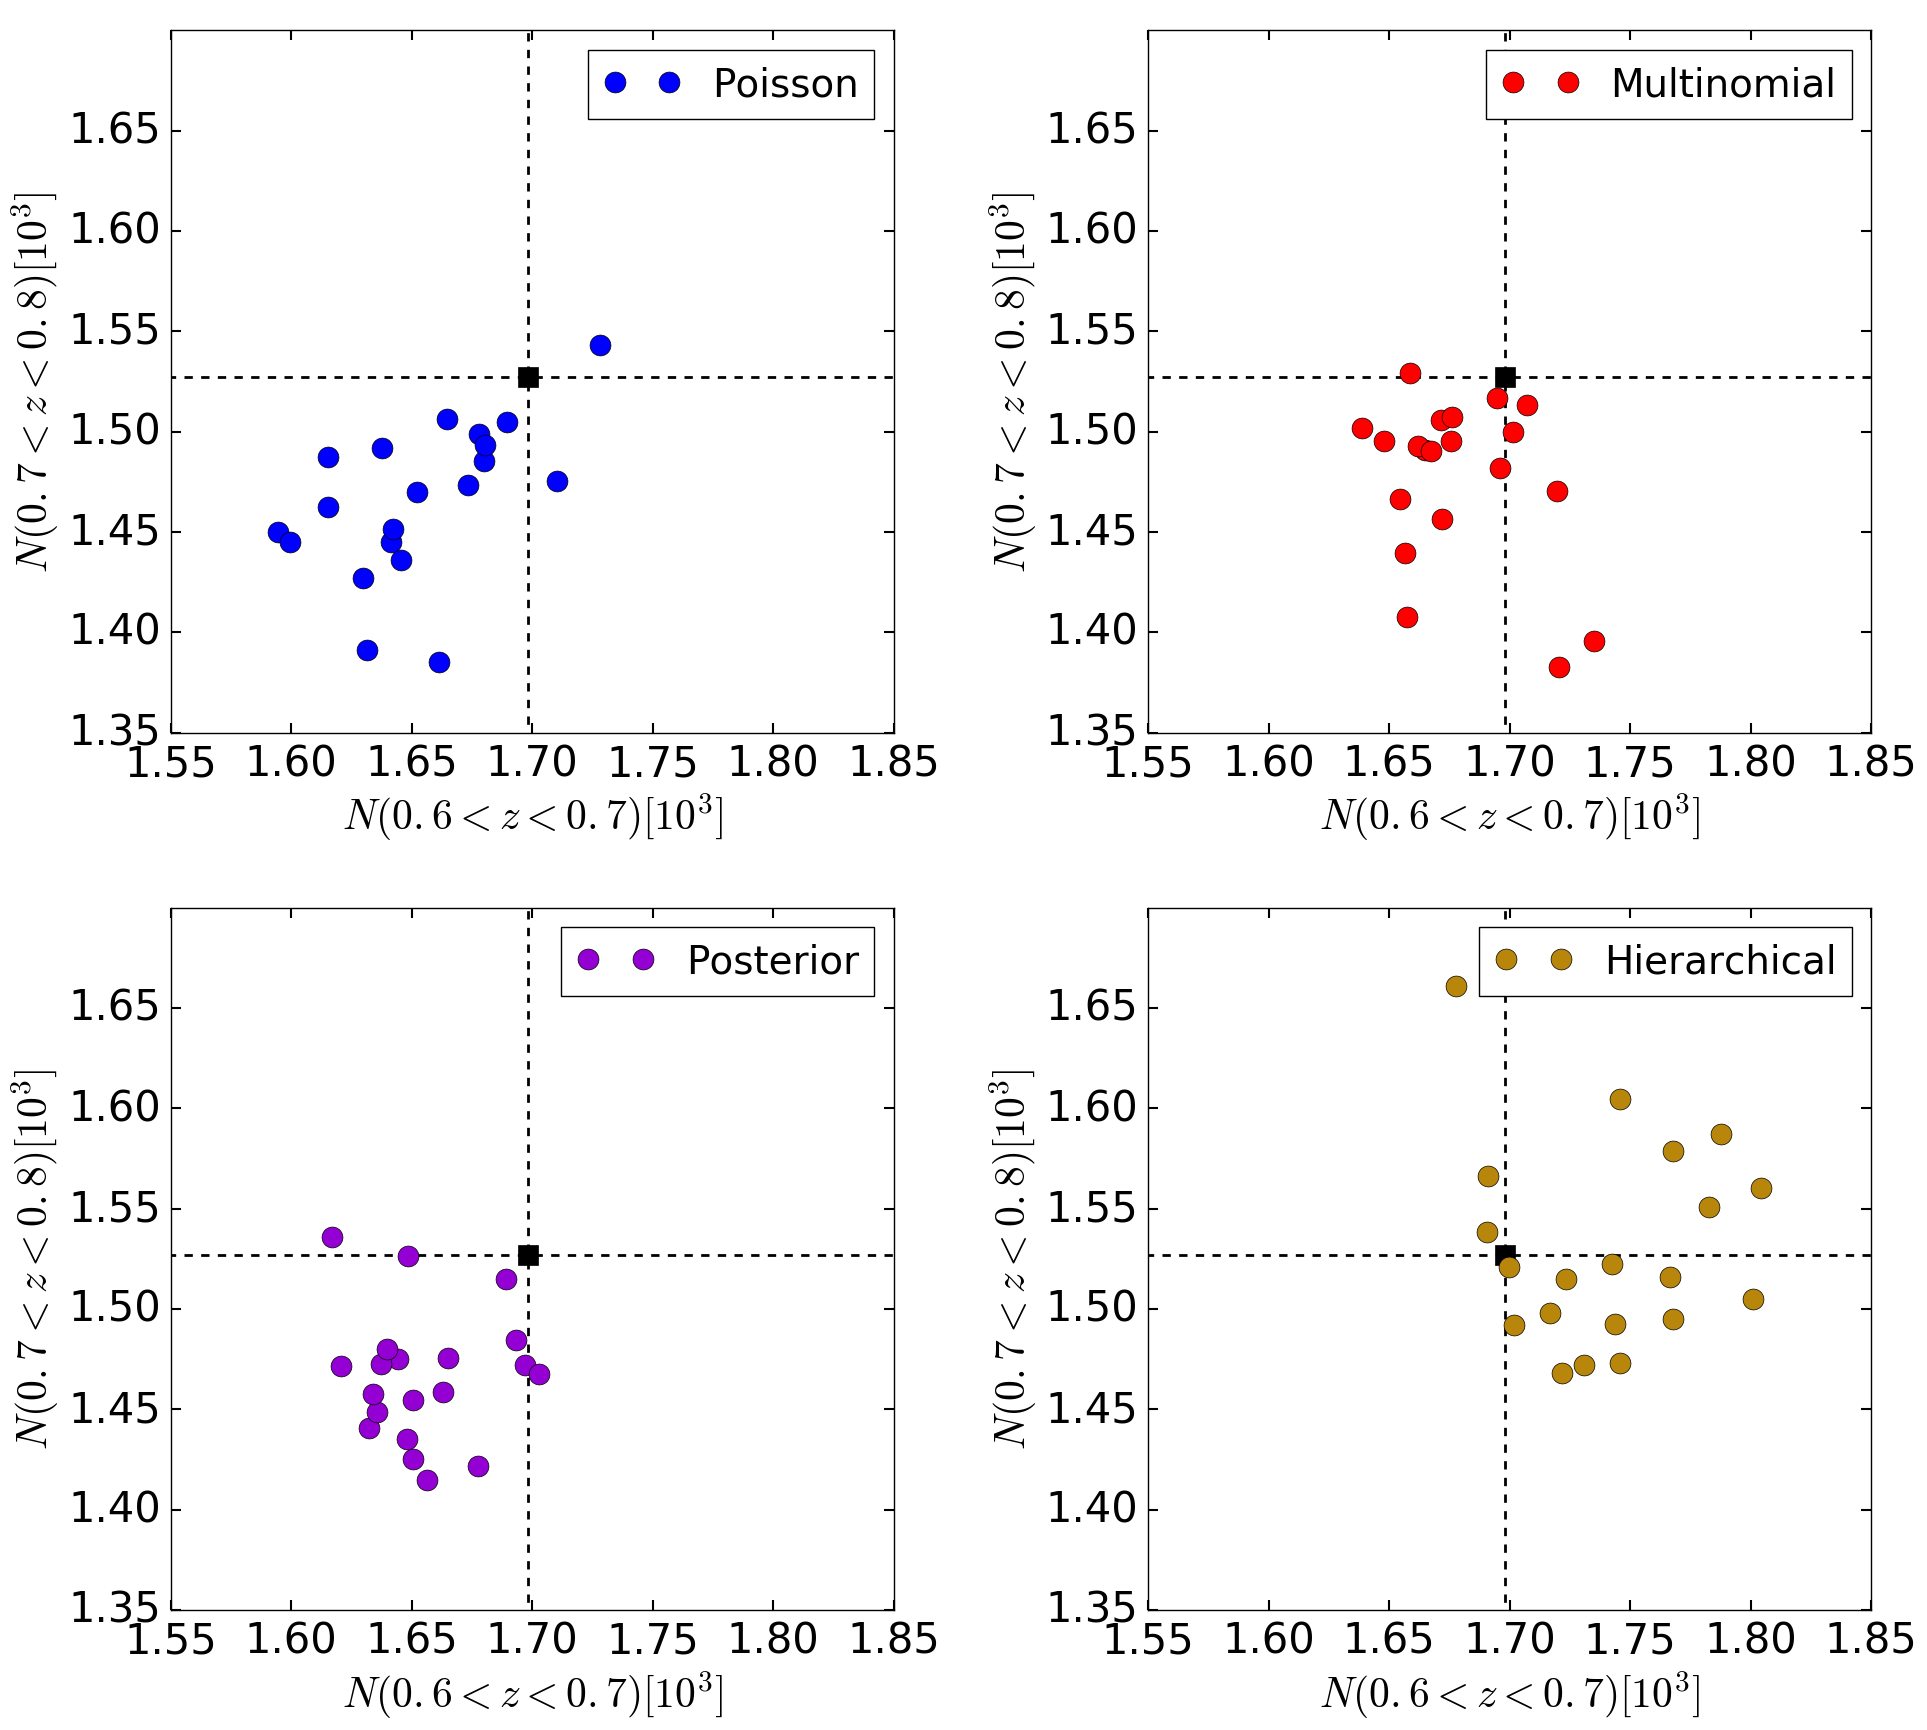

In [65]:
figure(figsize=(20,18))
subplot(2,2,1)
vlines(pdf[60:70].sum()/pdf.sum()*Nobs/1e3, 0, 100, lw=2, colors='black', linestyles='--')
hlines(pdf[70:80].sum()/pdf.sum()*Nobs/1e3, 0, 100, lw=2, colors='black', linestyles='--')
plot(pdf[60:70].sum()/pdf.sum()*Nobs/1e3, pdf[70:80].sum()/pdf.sum()*Nobs/1e3, 's', color='black', markersize=15)
plot(z1_samples[:,60:70].sum(axis=1)/1e3, z1_samples[:,70:80].sum(axis=1)/1e3, 'o', color='blue', label='Poisson', 
     markersize=15)
ylim([1.35, 1.7])
xlim([1.55, 1.85])
xlabel('$N(0.6<z<0.7) [10^3]$')
ylabel('$N(0.7<z<0.8) [10^3]$')
legend(fontsize=28, loc=1)
tight_layout()
subplot(2,2,2)
vlines(pdf[60:70].sum()/pdf.sum()*Nobs/1e3, 0, 100, lw=2, colors='black', linestyles='--')
hlines(pdf[70:80].sum()/pdf.sum()*Nobs/1e3, 0, 100, lw=2, colors='black', linestyles='--')
plot(pdf[60:70].sum()/pdf.sum()*Nobs/1e3, pdf[70:80].sum()/pdf.sum()*Nobs/1e3, 's', color='black', markersize=15)
plot(z2_samples[:,60:70].sum(axis=1)/1e3, z2_samples[:,70:80].sum(axis=1)/1e3, 'o', color='red', label='Multinomial',
     markersize=15)
ylim([1.35, 1.7])
xlim([1.55, 1.85])
xlabel('$N(0.6<z<0.7) [10^3]$')
ylabel('$N(0.7<z<0.8) [10^3]$')
legend(fontsize=28, loc=1)
tight_layout()
subplot(2,2,3)
vlines(pdf[60:70].sum()/pdf.sum()*Nobs/1e3, 0, 100, lw=2, colors='black', linestyles='--')
hlines(pdf[70:80].sum()/pdf.sum()*Nobs/1e3, 0, 100, lw=2, colors='black', linestyles='--')
plot(pdf[60:70].sum()/pdf.sum()*Nobs/1e3, pdf[70:80].sum()/pdf.sum()*Nobs/1e3, 's', color='black', markersize=15)
plot(z3_samples[:,60:70].sum(axis=1)/1e3, z3_samples[:,70:80].sum(axis=1)/1e3, 'o', color='darkviolet', label='Posterior',
     markersize=15)
ylim([1.35, 1.7])
xlim([1.55, 1.85])
xlabel('$N(0.6<z<0.7) [10^3]$')
ylabel('$N(0.7<z<0.8) [10^3]$')
legend(fontsize=28, loc=1)
tight_layout()
subplot(2,2,4)
vlines(pdf[60:70].sum()/pdf.sum()*Nobs/1e3, 0, 100, lw=2, colors='black', linestyles='--')
hlines(pdf[70:80].sum()/pdf.sum()*Nobs/1e3, 0, 100, lw=2, colors='black', linestyles='--')
plot(pdf[60:70].sum()/pdf.sum()*Nobs/1e3, pdf[70:80].sum()/pdf.sum()*Nobs/1e3, 's', color='black', markersize=15)
plot(z4_samples_t[:,60:70].sum(axis=1)/1e3, z4_samples_t[:,70:80].sum(axis=1)/1e3, 'o', 
     color='darkgoldenrod', label='Hierarchical', markersize=15)
ylim([1.35, 1.7])
xlim([1.55, 1.85])
xlabel('$N(0.6<z<0.7) [10^3]$')
ylabel('$N(0.7<z<0.8) [10^3]$')
legend(fontsize=28, loc=1)
tight_layout()

We see similar behavior to our original model except that our higher-resolution $N(\mathbf{z}|\mathbf{g})$ estimate appears to be somewhat better behaved.